# TODO: REMEMBER TO COMMENT ALL CODE BLOCKS

# CIS545: Big Data Analytics Project
**Coronary Heart Disease Prediction**

*Abhinav Bandaru, Steven Phan, Mikaela Kuan*

# SECTION I: DATA SOURCE

## 1.1 About the Data

The data used is obtained from [BRFS Survey](https://www.cdc.gov/brfss/annual_data/annual_2021.html) conducted in 2021. The original data was available .xpt format and was label encoded using [this](https://www.cdc.gov/brfss/annual_data/2021/pdf/codebook21_llcp-v2-508.pdf) configuration.

The dataset 'final_dataset.csv' can be accessed here for reproducibility purposes.


Due to encoding compatibility issues, it was subjected to a superficial round of feature selection and converted into a csv format using R. Here's the code:

```
library(rlang)
library(tidyverse)
library(dplyr)

data <- read_xpt("LLCP2021.XPT")
filtered_rows <- c("_STATE", "IMONTH", "IYEAR", "NUMADULT", "HHADULT", "SEXVAR", "GENHLTH",
                   "PHYSHLTH", "MENTHLTH", "PRIMINSR", "PERSDOC3", "CHECKUP1", "EXERANY2",
                   "CVDINFR4", "CVDCRHD4", "CVDSTRK3", "CHCSCNCR", "CHCOCNCR", "CHCCOPD3",
                   "ADDEPEV3", "CHCKDNY2", "DIABETE4", "HAVARTH5", "MARITAL", "EDUCA", "VETERAN3",
                   "EMPLOY1", "CHILDREN", "INCOME3", "WEIGHT2", "HEIGHT3", "FLUSHOT7",
                   'CNCRTYP1','CSRVDEIN','CSRVCLIN', '_METSTAT', '_URBSTAT', '_IMPRACE',
                   "_RFHYPE6", "_RFDRHV7", "SMOKE100", "ECIGNOW1", "_VEGESU1", "_FRUTSU1",
                   "_RFCHOL3", "_LTASTH1", "_AGEG5YR", "FRNCHDA_")
temp_data <- select(data, filtered_rows)

write.csv(temp_data, "final_dataset.csv", row.names = FALSE)
```

## 1.2 Authors' Note


*   We hereby declare that all three of the aforementioned authors have equally contributed to the following project.
*   We hereby declare that all the code available in this project has not been plagiarised.



# SECTION II: INITIAL DATA EXPLORATION

## 2.1 Importing the necessary libraries

We imported the following relevant libraries to our notebook for data processing, cleaning, visualization, exploratory data analysis (EDA), and modeling. The main libraries used were pandas, matplotlib, and sklearn.

In [ ]:
!pip install shap

In [ ]:
# Importing the Necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
import shap
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report

%matplotlib inline

## 2.2 Reading in the dataset

We imported the dataset containing the selected variables from the BRFSS dataset that was processed in R, as mentioned previously.

In [ ]:
# Reading in the dataset

df = pd.read_csv('final_dataset.csv')

## 2.3 Examining the dataset

To gain a better understanding of the dataset, we first look at the dimensions and descriptive statistics. The dataset currently has 406294 samples and 48 features. By looking at the datatypes, we see that most features are categorical.

In [ ]:
# Examining the dataset

print("Dimensions: ", df.shape)
print("Information: ", df.info())
print("Statistical Measures: ",  df.describe())
print("Statistical Measures: ",  df.isna().sum())

Dimensions:  (406294, 48)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406294 entries, 0 to 406293
Data columns (total 48 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    406294 non-null  int64  
 1   IMONTH    406294 non-null  int64  
 2   IYEAR     406294 non-null  int64  
 3   NUMADULT  109746 non-null  float64
 4   HHADULT   296527 non-null  float64
 5   SEXVAR    406294 non-null  int64  
 6   GENHLTH   406290 non-null  float64
 7   PHYSHLTH  406291 non-null  float64
 8   MENTHLTH  406292 non-null  float64
 9   PRIMINSR  406291 non-null  float64
 10  PERSDOC3  406292 non-null  float64
 11  CHECKUP1  406292 non-null  float64
 12  EXERANY2  406292 non-null  float64
 13  CVDINFR4  406292 non-null  float64
 14  CVDCRHD4  406292 non-null  float64
 15  CVDSTRK3  406292 non-null  float64
 16  CHCSCNCR  406292 non-null  float64
 17  CHCOCNCR  406291 non-null  float64
 18  CHCCOPD3  406291 non-null  float64
 19  ADDEPEV3  406291 n

# SECTION III: DATA CLEANING

## 3.1 Initial Feature Selection

In the previous section, we noticed some features had a large number of null values. As such, we removed these features from our dataset.

In [ ]:
# Dropping an initial set of irrelevant columns

df = df.drop(['CSRVCLIN', 'CSRVDEIN', 'CNCRTYP1', 'NUMADULT', 'HHADULT'], axis=1)

## 3.2 Null Values

For simplicity, we choose to remove rows containing the null values from the dataset instead of imputing the missing values. Our dataset is sufficiently large, so we do not need to worry too much about skewed results caused by a small dataset.

In [ ]:
# Dropping the NULL values

print(df.isna().sum())
df.dropna(inplace=True)

_STATE          0
IMONTH          0
IYEAR           0
SEXVAR          0
GENHLTH         4
PHYSHLTH        3
MENTHLTH        2
PRIMINSR        3
PERSDOC3        2
CHECKUP1        2
EXERANY2        2
CVDINFR4        2
CVDCRHD4        2
CVDSTRK3        2
CHCSCNCR        2
CHCOCNCR        3
CHCCOPD3        3
ADDEPEV3        3
CHCKDNY2        3
DIABETE4        3
HAVARTH5        3
MARITAL         5
EDUCA           5
VETERAN3     1583
EMPLOY1      3451
CHILDREN     5794
INCOME3      8384
WEIGHT2     11179
HEIGHT3     12248
FLUSHOT7    26180
_METSTAT        0
_URBSTAT        0
_IMPRACE        0
_RFHYPE6        0
_RFDRHV7        0
SMOKE100    20059
ECIGNOW1    21779
_VEGESU1    56778
_FRUTSU1    48189
_RFCHOL3    57402
_LTASTH1        0
_AGEG5YR        0
FRNCHDA_    42384
dtype: int64


## 3.3 Dealing with Ambiguous responses

Responses in the dataset included "Don't Know/Refused to Answer." We decided to drop such inconclusive responses. In order to aid the data cleaning, we created helper functions to drop/combine rows with a specific value in a column and, convert from imperial to metric.

In [ ]:
# Defining helper functions

# Drops specific values in a column
def drop_by_col_value(df, value_list, col_name):
  drop_indices = df[df[col_name].isin(value_list)].index
  return df.drop(drop_indices)

# Converts the metric of weight and height
def FtIn_to_Cm(x):
  hundreds = int(str(x)[0])
  return (x - hundreds * 100 + hundreds * 12) * 2.54

# Replaces the value in a column. Used to combine values in a column
def change_value(df, col_name, a, b):
  df[col_name] = df[col_name].replace(a, b)
  return df

In [ ]:
# Dropping columns with values 7 and/or 9
# 7 - Indicates an ambiguous response
# 9 - Indicates a denied to answer

df = drop_by_col_value(df, [7,9], 'EXERANY2')
df = drop_by_col_value(df, [7,9], 'CVDINFR4')
df = drop_by_col_value(df, [7,9], 'CVDCRHD4')
df = drop_by_col_value(df, [7,9], 'CVDSTRK3')
df = drop_by_col_value(df, [7,9], 'CHCSCNCR')
df = drop_by_col_value(df, [7,9], 'CHCOCNCR')
df = drop_by_col_value(df, [7,9], 'CHCCOPD3')
df = drop_by_col_value(df, [7,9], 'ADDEPEV3')
df = drop_by_col_value(df, [7,9], 'CHCKDNY2')
df = drop_by_col_value(df, [7,9], 'DIABETE4')
df = drop_by_col_value(df, [7,9], 'HAVARTH5')
df = drop_by_col_value(df, [7,9], 'VETERAN3')
df = drop_by_col_value(df, [7,9], 'FLUSHOT7')
df = drop_by_col_value(df, [7,9], 'SMOKE100')
df = drop_by_col_value(df, [7,9], 'GENHLTH')
df = drop_by_col_value(df, [7,9], 'ECIGNOW1')
df = drop_by_col_value(df, [7,9], 'EXERANY2')
df = drop_by_col_value(df, [7,9], 'CVDINFR4')
df = drop_by_col_value(df, [7,9], 'CVDCRHD4')
df = drop_by_col_value(df, [7,9], 'CVDSTRK3')
df = drop_by_col_value(df, [7,9], 'CHCSCNCR')
df = drop_by_col_value(df, [7,9], 'CHCOCNCR')
df = drop_by_col_value(df, [7,9], 'CHCCOPD3')
df = drop_by_col_value(df, [7,9], 'ADDEPEV3')
df = drop_by_col_value(df, [7,9], 'CHCKDNY2')
df = drop_by_col_value(df, [7,9], 'DIABETE4')
df = drop_by_col_value(df, [7,9], 'HAVARTH5')
df = drop_by_col_value(df, [7,9], 'VETERAN3')
df = drop_by_col_value(df, [7,9], 'FLUSHOT7')
df = drop_by_col_value(df, [7,9], 'SMOKE100')
df = drop_by_col_value(df, [7,9], 'GENHLTH')
df = drop_by_col_value(df, [7,9], 'ECIGNOW1')

df = drop_by_col_value(df, [14], '_AGEG5YR')
df = drop_by_col_value(df, [14], '_AGEG5YR')

df = drop_by_col_value(df, [9], 'MARITAL')
df = drop_by_col_value(df, [9], 'EMPLOY1')
df = drop_by_col_value(df, [9], '_RFHYPE6')
df = drop_by_col_value(df, [9], '_RFDRHV7')
df = drop_by_col_value(df, [9], '_RFCHOL3')
df = drop_by_col_value(df, [9], '_LTASTH1')
df = drop_by_col_value(df, [9], 'PERSDOC3')
df = drop_by_col_value(df, [9], 'EDUCA')
df = drop_by_col_value(df, [9], 'CHECKUP1')
df = drop_by_col_value(df, [9], 'MARITAL')
df = drop_by_col_value(df, [9], 'EMPLOY1')
df = drop_by_col_value(df, [9], '_RFHYPE6')
df = drop_by_col_value(df, [9], '_RFDRHV7')
df = drop_by_col_value(df, [9], '_RFCHOL3')
df = drop_by_col_value(df, [9], '_LTASTH1')
df = drop_by_col_value(df, [9], 'PERSDOC3')
df = drop_by_col_value(df, [9], 'EDUCA')
df = drop_by_col_value(df, [9], 'CHECKUP1')

df = drop_by_col_value(df, [99], 'CHILDREN')

df = drop_by_col_value(df, [77, 99], 'INCOME3')
df = drop_by_col_value(df, [77, 99], 'PHYSHLTH')
df = drop_by_col_value(df, [77, 99], 'MENTHLTH')
df = drop_by_col_value(df, [77, 99], 'PRIMINSR')

df = drop_by_col_value(df, [7777, 9999], 'WEIGHT2')
df = drop_by_col_value(df, [7777, 9999], 'HEIGHT3')

## 3.4 Merging Similar Responses

Some responses in the dataset had multiple types of responses for a "yes" value (e.g. "yes" and "yes, more than one"). We decided to combine these responses into a singular "yes" response to reduce the complexity.

We also convert values to be consistent, such as converting all units from imperial to metric or making None values 0.

In [ ]:
# Combining, Encoding values into a meaningful representation
# 88 - Indicates a None response which is better represented by 0

df = change_value(df, 'PHYSHLTH', 88, 0)
df = change_value(df, 'MENTHLTH', 88, 0)
df = change_value(df, 'PRIMINSR', 88, 0)
df = change_value(df, 'CHILDREN', 88, 0)


# Combining various versions of 'yes' and 'no' responses into 2 binary categories 'yes' and 'no'
# Eg: 'yes, more than one', 'yes' are combined into 'yes'

df = change_value(df, 'CHECKUP1', 7, 4)
df = change_value(df, 'PERSDOC3', 2, 1)
df = change_value(df, 'PERSDOC3', 7, 3)
df = change_value(df, 'DIABETE4', 2, 1)
df = change_value(df, 'DIABETE4', 4, 3)


# Converting height and weight into the metric system

df['WEIGHT2'] = df['WEIGHT2'].apply(lambda x: x - 9000 if x >= 9000 else x / 2.205)
df['HEIGHT3'] = df['HEIGHT3'].apply(lambda x: x - 9000 if x >= 9000 else FtIn_to_Cm(x))

#change ecig values to appropriate scale (e.g. 0 is never used)
ecig_dict = {4:0, 3:1, 2:2, 1:3}
df['ECIGNOW1'] = df['ECIGNOW1'].apply(lambda x: ecig_dict.get(x))

## 3.5 Reverse Encoding

Currently the data is encoded and cleaned. To make EDA and visualization easier, we will reverse encode our dataset.

In [ ]:
df.head()

,_STATE,IMONTH,IYEAR,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,PRIMINSR,PERSDOC3,CHECKUP1,...,_RFHYPE6,_RFDRHV7,SMOKE100,ECIGNOW1,_VEGESU1,_FRUTSU1,_RFCHOL3,_LTASTH1,_AGEG5YR,FRNCHDA_
0,1,1,2021,2,5.0,20.0,10.0,3.0,1.0,2.0,...,1,1,1.0,1,214.0,100.0,2.0,2,11,43.0
2,1,1,2021,2,2.0,0.0,0.0,2.0,1.0,1.0,...,2,1,2.0,1,71.0,100.0,1.0,1,11,14.0
3,1,1,2021,2,2.0,0.0,10.0,2.0,1.0,1.0,...,2,1,2.0,1,165.0,114.0,2.0,1,9,57.0
5,1,1,2021,1,3.0,0.0,0.0,3.0,1.0,1.0,...,1,1,1.0,1,42.0,29.0,1.0,1,13,0.0
9,1,2,2021,2,3.0,25.0,5.0,3.0,1.0,1.0,...,2,1,1.0,1,158.0,100.0,1.0,1,10,29.0


Numerically encoded values are changed back to their human-readable value.

In [ ]:
# Function used to map the data from numbers (encoding) to descriptions (strings)
# This step is performed for better EDA understanding

def to_text_map(df, col_name, mapp):
  df[col_name] = df[col_name].map(mapp)
  return df

state_map = {1:'Alabama',2:'Alaska',4:'Arizona',5:'Arkansas',6:'California',
             8:'Colorado',9:'Connecticut',10:'Delaware', 11:'District of Columbia',
             13:'Georgia',15:'Hawaii',16:'Idaho',17:'Illinois',18:'Indiana',19:'Iowa',20:'Kansas',
             21:'Kentucky',22:'Louisiana',23:'Maine',24:'Maryland',25:'Massachusetts',
             26:'Michigan',27:'Minnesota',28:'Mississippi',29:'Missouri',30:'Montana',31:'Nebraska',
             32:'Nevada',33:'New Hampshire',34:'New Jersey',35:'New Mexico',36:'New York',
             37:'North Carolina',38:'North Dakota',39:'Ohio',40:'Oklahoma',41:'Oregon',
             42:'Pennsylvania',44:'Rhode Island',45:'South Carolina',46:'South Dakota',
             47:'Tennessee',48:'Texas',49:'Utah',50:'Vermont',51:'Virginia',53:'Washington',
             54:'West Virginia',55:'Wisconsin',56:'Wyoming',66:'Guam',72:'Puerto Rico',78:'Virgin Islands'}

month_map = {1:'January',2:'February',3:'March',4:'April',5:'May',
             6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}


# Reverse Encoding

df_cleaned = df

# Sex
df_cleaned = to_text_map(df_cleaned, 'SEXVAR', {1: 'Male', 2: 'Female'})

# General_Health
df_cleaned = to_text_map(df_cleaned, 'GENHLTH', {1: 'Excellent', 2: 'Very Good', 3: 'Good', 4: 'Fair', 5: 'Poor'})

# Personal_Doctor
df_cleaned = to_text_map(df_cleaned, 'PERSDOC3', {1: 'Yes', 3: 'No'})

# Last_Checkup
df_cleaned = to_text_map(df_cleaned, 'CHECKUP1', {1: 'Within Past Year', 2: 'Within past 2 years', 3:'Within past 5 years',
                                                  4:'5 or more years ago', 8:'Never'})

# Exercise
df_cleaned = to_text_map(df_cleaned, 'EXERANY2', {1: 'Yes', 2: 'No'})

# Heart_Attack
df_cleaned = to_text_map(df_cleaned, 'CVDINFR4', {1: 'Yes', 2: 'No'})

 ## TARGET VARIABLE
df_cleaned = to_text_map(df_cleaned, 'CVDCRHD4', {1: 'Yes', 2: 'No'})

# Heart_Stroke
df_cleaned = to_text_map(df_cleaned, 'CVDSTRK3', {1: 'Yes', 2: 'No'})

# Skin_Cancer
df_cleaned = to_text_map(df_cleaned, 'CHCSCNCR', {1: 'Yes', 2: 'No'})

# Other_Cancer
df_cleaned = to_text_map(df_cleaned, 'CHCOCNCR', {1: 'Yes', 2: 'No'})

# Pulmonary_Disease
df_cleaned = to_text_map(df_cleaned, 'CHCCOPD3', {1: 'Yes', 2: 'No'})

# Depression
df_cleaned = to_text_map(df_cleaned, 'ADDEPEV3', {1: 'Yes', 2: 'No'})

# Kidney_Disease
df_cleaned = to_text_map(df_cleaned, 'CHCKDNY2', {1: 'Yes', 2: 'No'})

# Diabetes
df_cleaned = to_text_map(df_cleaned, 'DIABETE4', {1: 'Yes', 3: 'No'})

# Arthritis
df_cleaned = to_text_map(df_cleaned, 'HAVARTH5', {1: 'Yes', 2: 'No'})

# Marital
df_cleaned = to_text_map(df_cleaned, 'MARITAL', {1: 'Married', 2: 'Divorced', 3: 'Widowed', 4: 'Separated', 5: 'Never married', 6:'A member of an unmarried couple'})

# Education
df_cleaned = to_text_map(df_cleaned, 'EDUCA', {1: 'None', 2: 'Elementary', 3: 'Some High School', 4: 'High School Graduate', 5: 'Some College', 6:'College Graduate'})

# Veteran
df_cleaned = to_text_map(df_cleaned, 'VETERAN3', {1: 'Yes', 2: 'No'})

# Employment
df_cleaned = to_text_map(df_cleaned, 'EMPLOY1', {1: 'Employed', 2: 'Self-employed', 3: 'Out of work for 1 year or more', 4: 'Out of work for < 1 year', 5: 'Homemaker', 6:'Student', 7:'Retired', 8:'Unable to Work'})

# Income
df_cleaned = to_text_map(df_cleaned, 'INCOME3',
            {1: 'Less than $10,000', 2: '$10,000 - $15,000', 3: '$15,000 - $20,000', 4: '$20,000 - $25,000', 5: '$25,000 - $35,000',
             6:'$35,000 - $50,000', 7:'$50,000 - $75,000', 8:'$75,000 - $100,000', 9:'$100,000 - $150,000', 10:'$150,000 - $200,000',
             11:'$200,000 or more'})

# Flushot
df_cleaned = to_text_map(df_cleaned, 'FLUSHOT7', {1: 'Yes', 2: 'No'})

# Metropolitan_Status
df_cleaned = to_text_map(df_cleaned, '_METSTAT', {1: 'Metropolitan counties', 2: 'Nonmetropolitan counties'})

# Urban_Status
df_cleaned = to_text_map(df_cleaned, '_URBSTAT', {1: 'Urban counties', 2: 'Rural counties'})

# Race
df_cleaned = to_text_map(df_cleaned, '_IMPRACE', {1: 'White', 2: 'Black', 3:'Asian', 4:'American Indian/Alaskan Native', 5:'Hispanic', 6:'Other race'})

# High_BP
df_cleaned = to_text_map(df_cleaned, '_RFHYPE6', {1: 'No', 2: 'Yes'})

# Alcohol_Consumption
df_cleaned = to_text_map(df_cleaned, '_RFDRHV7', {1: 'No', 2: 'Yes'})

# Smoking
df_cleaned = to_text_map(df_cleaned, 'SMOKE100', {1: 'Yes', 2: 'No'})

# E_Smoking
df_cleaned = to_text_map(df_cleaned, 'ECIGNOW1', {0: 'Never used e-cigs', 1: 'Not at all', 2:'Some days', 3:'Every day'})

# High_Cholesterol
df_cleaned = to_text_map(df_cleaned, '_RFCHOL3', {1: 'No', 2: 'Yes'})

# Asthma
df_cleaned = to_text_map(df_cleaned, '_LTASTH1', {1: 'No', 2: 'Yes'})

# Age
df_cleaned = to_text_map(df_cleaned, '_AGEG5YR', {1:'18-24', 2:'25-29', 3:'30-34', 4:'35-39', 5:'40-44',
                                                  6:'45-49', 7:'50-54', 8:'55-59', 9:'60-64', 10:'65-69',
                                                  11:'70-74', 12:'75-79', 13:'80+'})
# State
df_cleaned['_STATE'] = df_cleaned['_STATE'].apply(lambda x: state_map[x])

# Month
df_cleaned['IMONTH'] = df_cleaned['IMONTH'].apply(lambda x: month_map[x])


Now, let's see how the data looks.

In [ ]:
df_cleaned.head()

,_STATE,IMONTH,IYEAR,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,PRIMINSR,PERSDOC3,CHECKUP1,...,_RFHYPE6,_RFDRHV7,SMOKE100,ECIGNOW1,_VEGESU1,_FRUTSU1,_RFCHOL3,_LTASTH1,_AGEG5YR,FRNCHDA_
0,Alabama,January,2021,Female,Poor,20.0,10.0,3.0,Yes,Within past 2 years,...,No,No,Yes,Not at all,214.0,100.0,Yes,Yes,70-74,43.0
2,Alabama,January,2021,Female,Very Good,0.0,0.0,2.0,Yes,Within Past Year,...,Yes,No,No,Not at all,71.0,100.0,No,No,70-74,14.0
3,Alabama,January,2021,Female,Very Good,0.0,10.0,2.0,Yes,Within Past Year,...,Yes,No,No,Not at all,165.0,114.0,Yes,No,60-64,57.0
5,Alabama,January,2021,Male,Good,0.0,0.0,3.0,Yes,Within Past Year,...,No,No,Yes,Not at all,42.0,29.0,No,No,80+,0.0
9,Alabama,February,2021,Female,Good,25.0,5.0,3.0,Yes,Within Past Year,...,Yes,No,Yes,Not at all,158.0,100.0,No,No,65-69,29.0


## 3.6 Renaming the Columns

We now change the columns names to be more descriptive and human-readable.

In [ ]:
# Renaming the Columns with appropriate names

# Sex
df_cleaned.rename(columns={'SEXVAR': 'Sex'}, inplace=True)

# General_Health
df_cleaned.rename(columns={'GENHLTH': 'General_Health'}, inplace=True)

# Personal_Doctor
df_cleaned.rename(columns={'PERSDOC3': 'Personal_Doctor'}, inplace=True)

# Last_Checkup
df_cleaned.rename(columns={'CHECKUP1': 'Last_Checkup'}, inplace=True)

# Exercise
df_cleaned.rename(columns={'EXERANY2': 'Exercise'}, inplace=True)

# Heart_Attack
df_cleaned.rename(columns={'CVDINFR4': 'Heart_Attack'}, inplace=True)

 ## TARGET VARIABLE
df_cleaned.rename(columns={'CVDCRHD4': 'Heart_Disease'}, inplace=True)

# Heart_Stroke
df_cleaned.rename(columns={'CVDSTRK3': 'Heart_Stroke'}, inplace=True)

# Skin_Cancer
df_cleaned.rename(columns={'CHCSCNCR': 'Skin_Cancer'}, inplace=True)

# Other_Cancer
df_cleaned.rename(columns={'CHCOCNCR': 'Other_Cancer'}, inplace=True)

# Pulmonary_Disease
df_cleaned.rename(columns={'CHCCOPD3': 'Pulmonary_Disease'}, inplace=True)

# Depression
df_cleaned.rename(columns={'ADDEPEV3': 'Depression'}, inplace=True)

# Kidney_Disease
df_cleaned.rename(columns={'CHCKDNY2': 'Kidney_Disease'}, inplace=True)

# Diabetes
df_cleaned.rename(columns={'DIABETE4': 'Diabetes'}, inplace=True)

# Arthritis
df_cleaned.rename(columns={'HAVARTH5': 'Arthritis'}, inplace=True)

# Marital
df_cleaned.rename(columns={'MARITAL': 'Marital'}, inplace=True)

# Education
df_cleaned.rename(columns={'EDUCA': 'Education'}, inplace=True)

# Veteran
df_cleaned.rename(columns={'VETERAN3': 'Veteran'}, inplace=True)

# Employment
df_cleaned.rename(columns={'EMPLOY1': 'Employment'}, inplace=True)

# Income
df_cleaned.rename(columns={'INCOME3': 'Income'}, inplace=True)

# Flushot
df_cleaned.rename(columns={'FLUSHOT7': 'Flushot'}, inplace=True)

# Metropolitan_Status
df_cleaned.rename(columns={'_METSTAT': 'Metropolitan_Status'}, inplace=True)

# Urban_Status
df_cleaned.rename(columns={'_URBSTAT': 'Urban_Status'}, inplace=True)

# Race
df_cleaned.rename(columns={'_IMPRACE': 'Race'}, inplace=True)

# High_BP
df_cleaned.rename(columns={'_RFHYPE6': 'High_BP'}, inplace=True)

# Alcohol_Consumption
df_cleaned.rename(columns={'_RFDRHV7': 'Alcohol_Consumption'}, inplace=True)

# Smoking
df_cleaned.rename(columns={'SMOKE100': 'Smoking'}, inplace=True)

# E_Smoking
df_cleaned.rename(columns={'ECIGNOW1': 'E_Smoking'}, inplace=True)

# High_Cholesterol
df_cleaned.rename(columns={'_RFCHOL3': 'High_Cholesterol'}, inplace=True)

# Asthma
df_cleaned.rename(columns={'_LTASTH1': 'Asthma'}, inplace=True)

# Age
df_cleaned.rename(columns={'_AGEG5YR': 'Age'}, inplace=True)

# Vegetables_Consumed
df_cleaned.rename(columns={'_VEGESU1': 'Vegetables_Consumed'}, inplace=True)

# Fruits_Consumed
df_cleaned.rename(columns={'_FRUTSU1': 'Fruits_Consumed'}, inplace=True)

# French Fry Intake
df_cleaned.rename(columns={'FRNCHDA_': 'French_Fry_Intake'}, inplace=True)

# Physical Health Not Good
df_cleaned.rename(columns={'PHYSHLTH': 'Physical_Health_Not_Good'}, inplace=True)

# Mental Health Not Good
df_cleaned.rename(columns={'MENTHLTH': 'Mental_Health_Not_Good'}, inplace=True)

# Health Insurance
df_cleaned.rename(columns={'PRIMINSR': 'Health_Insurance'}, inplace=True)

# Height
df_cleaned.rename(columns={'HEIGHT3': 'Height'}, inplace=True)

# Weight
df_cleaned.rename(columns={'WEIGHT2': 'Weight'}, inplace=True)

Note: Heart attack and heart stroke were removed at this step because we realized these two features may be too correlated with heart disease. It is also possible that a person gets a heart attack or heart stroke **after** being diagnosed with heart disease. But, our goal is to find factors to prevent those types of events from happening.

In [ ]:
df_encoded = df_cleaned
df_encoded.drop(['Heart_Attack', 'Heart_Stroke'], axis = 1, inplace = True)
df_encoded.head()

,_STATE,IMONTH,IYEAR,Sex,General_Health,Physical_Health_Not_Good,Mental_Health_Not_Good,Health_Insurance,Personal_Doctor,Last_Checkup,...,High_BP,Alcohol_Consumption,Smoking,E_Smoking,Vegetables_Consumed,Fruits_Consumed,High_Cholesterol,Asthma,Age,French_Fry_Intake
0,Alabama,January,2021,Female,Poor,20.0,10.0,3.0,Yes,Within past 2 years,...,No,No,Yes,Not at all,214.0,100.0,Yes,Yes,70-74,43.0
2,Alabama,January,2021,Female,Very Good,0.0,0.0,2.0,Yes,Within Past Year,...,Yes,No,No,Not at all,71.0,100.0,No,No,70-74,14.0
3,Alabama,January,2021,Female,Very Good,0.0,10.0,2.0,Yes,Within Past Year,...,Yes,No,No,Not at all,165.0,114.0,Yes,No,60-64,57.0
5,Alabama,January,2021,Male,Good,0.0,0.0,3.0,Yes,Within Past Year,...,No,No,Yes,Not at all,42.0,29.0,No,No,80+,0.0
9,Alabama,February,2021,Female,Good,25.0,5.0,3.0,Yes,Within Past Year,...,Yes,No,Yes,Not at all,158.0,100.0,No,No,65-69,29.0


## 3.7 Outlier Detection and Removal

---

Out initial analysis and exploration showed extreme outliers in - Vegetables_Consumed, Fruits_Consumed, French_Fry_Intake, and CHILDREN.



In [ ]:
Q1 = df_encoded['Vegetables_Consumed'].quantile(0.25)
Q3 = df_encoded['Vegetables_Consumed'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define bounds for what is considered an outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_encoded = df_encoded[(df_encoded['Vegetables_Consumed'] >= lower_bound) & (df_encoded['Vegetables_Consumed'] <= upper_bound)]



# Fruits Consumed
Q1 = df_encoded['Fruits_Consumed'].quantile(0.25)
Q3 = df_encoded['Fruits_Consumed'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define bounds for what is considered an outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_encoded = df_encoded[(df_encoded['Fruits_Consumed'] >= lower_bound) & (df_encoded['Fruits_Consumed'] <= upper_bound)]




# French Fry Intake
Q1 = df_encoded['French_Fry_Intake'].quantile(0.25)
Q3 = df_encoded['French_Fry_Intake'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define bounds for what is considered an outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_encoded = df_encoded[(df_encoded['French_Fry_Intake'] >= lower_bound) & (df_encoded['French_Fry_Intake'] <= upper_bound)]



# CHILDREN
Q1 = df_encoded['CHILDREN'].quantile(0.25)
Q3 = df_encoded['CHILDREN'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define bounds for what is considered an outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_encoded = df_encoded[(df_encoded['CHILDREN'] >= lower_bound) & (df_encoded['CHILDREN'] <= upper_bound)]

## 3.7 Final Dataset

The final dimesions of our dataset are

In [ ]:
print('Dimensions: ', df_encoded.shape)

Dimensions:  (177135, 41)


The features we have selected for our modeling are

In [ ]:
print('Selected Features: ', df_encoded.columns)

Selected Features:  Index(['_STATE', 'IMONTH', 'IYEAR', 'Sex', 'General_Health',
       'Physical_Health_Not_Good', 'Mental_Health_Not_Good',
       'Health_Insurance', 'Personal_Doctor', 'Last_Checkup', 'Exercise',
       'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Pulmonary_Disease',
       'Depression', 'Kidney_Disease', 'Diabetes', 'Arthritis', 'Marital',
       'Education', 'Veteran', 'Employment', 'CHILDREN', 'Income', 'Weight',
       'Height', 'Flushot', 'Metropolitan_Status', 'Urban_Status', 'Race',
       'High_BP', 'Alcohol_Consumption', 'Smoking', 'E_Smoking',
       'Vegetables_Consumed', 'Fruits_Consumed', 'High_Cholesterol', 'Asthma',
       'Age', 'French_Fry_Intake'],
      dtype='object')


In [ ]:
df_encoded['Employment'].unique()

array(['Retired', 'Employed', 'Unable to Work', 'Homemaker',
       'Self-employed', 'Out of work for 1 year or more',
       'Out of work for < 1 year', 'Student'], dtype=object)

Great! Now we can move onto EDA.

In [ ]:
# df_encoded.to_csv("final_final_cleaned.csv", index = False)

# SECTION IV: EXPLORATORY DATA ANALYSIS

## 4.1 Analyzing the distribution of Features

Let's take a look at the distribution of our numerical features. Most of the features appear to be skewed to the left, so we will have to keep that in mind for our modeling.

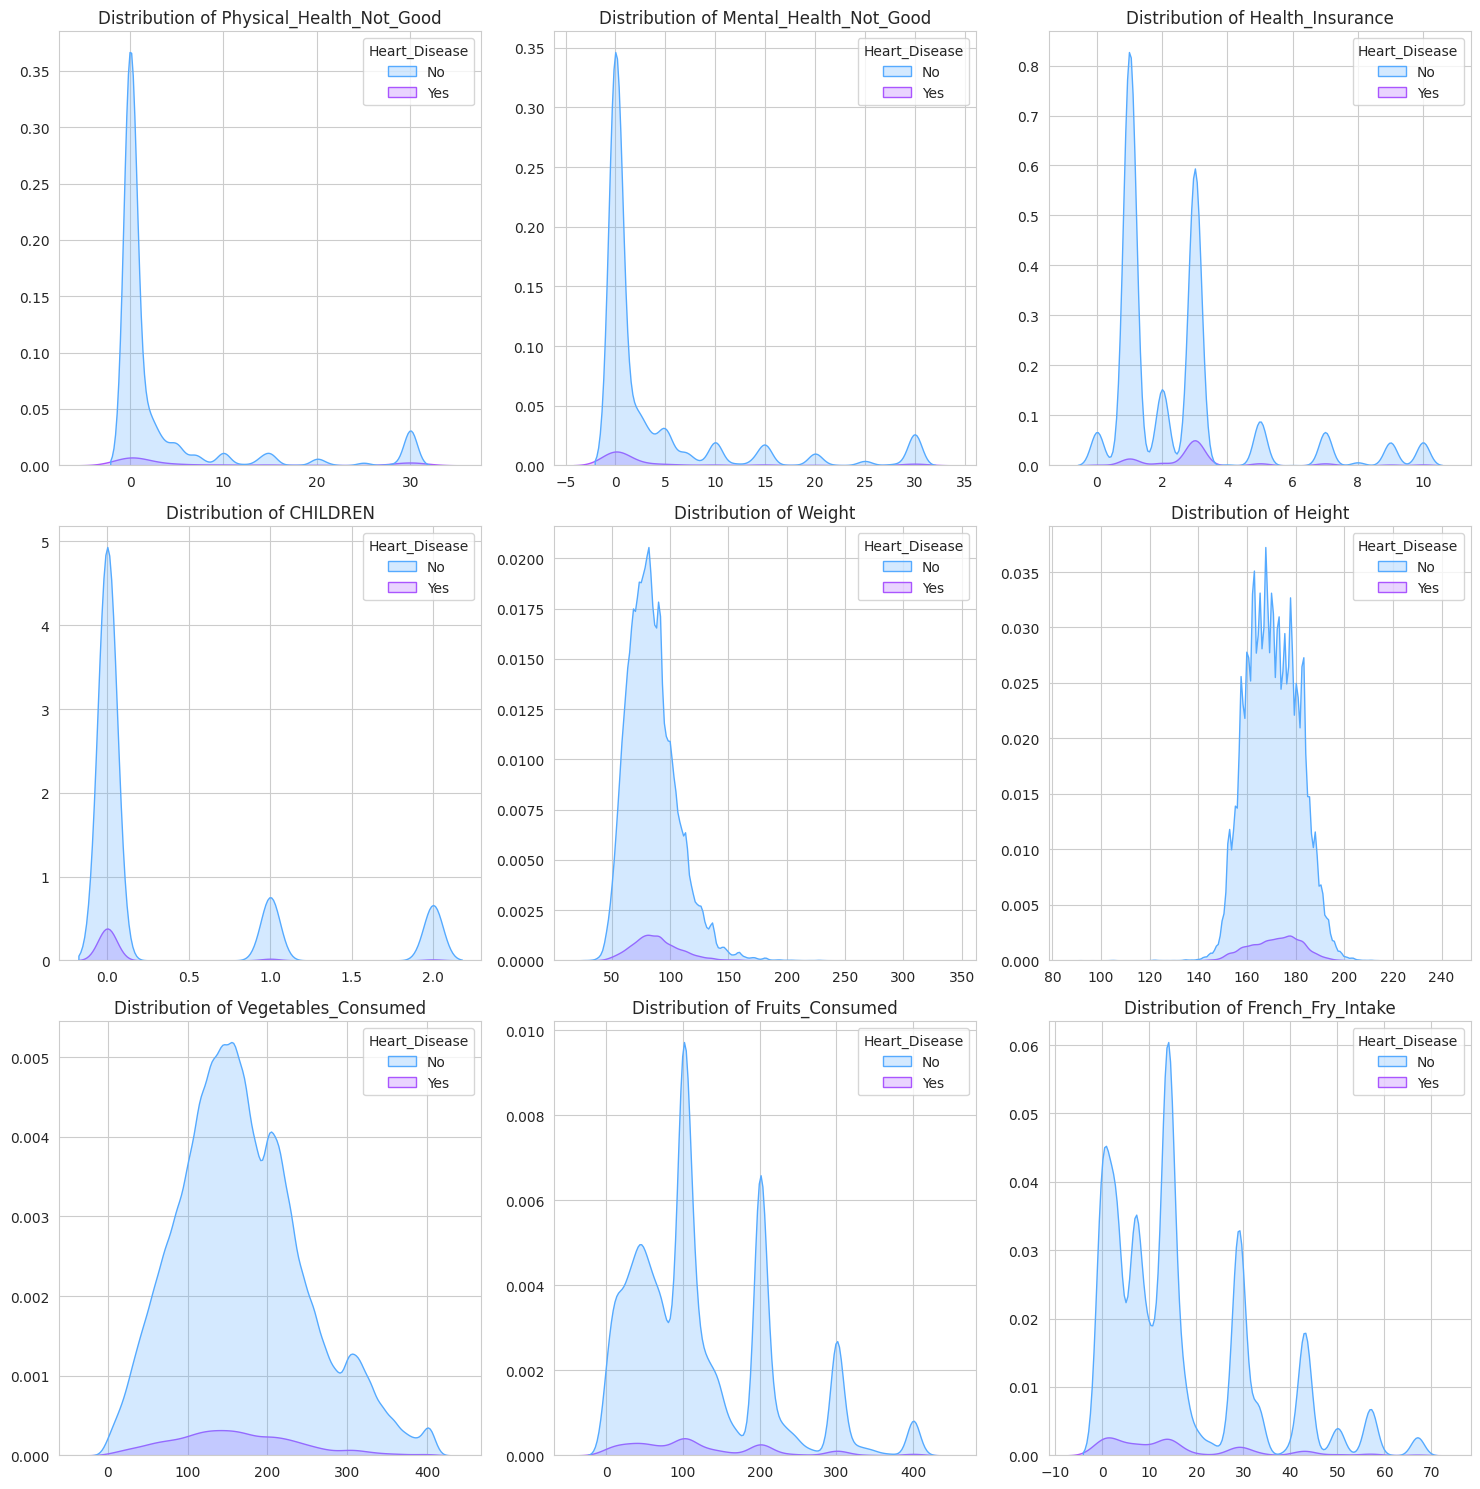

In [ ]:
# Selecting the 'float' datatype columns to view their distribution

num_col = list(df_encoded.select_dtypes('float').columns)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Determine the grid size
num_plots = len(num_col)
num_columns = 3
num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

# Initialize the figure with a determined grid size
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))  # Adjust the figure size as needed

# Flatten the array of axes, so it's easier to iterate over
axs = axs.flatten()

# Loop through the numerical variables and create KDE plots
for i, variable in enumerate(num_col):
    sns.kdeplot(data=df_encoded, x=variable, hue="Heart_Disease", palette="cool", fill=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {variable}')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

# Hiding any unused subplots that might be left over if the number of plots isn't a perfect fit for the grid
for ax in axs[num_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
print(df_encoded['Vegetables_Consumed'].describe())
print(df_encoded['Fruits_Consumed'].describe())
df_encoded['French_Fry_Intake'].describe()

count    177135.000000
mean        167.583075
std          78.825474
min           0.000000
25%         114.000000
50%         158.000000
75%         215.000000
max         407.000000
Name: Vegetables_Consumed, dtype: float64
count    177135.000000
mean        121.600135
std          89.601513
min           0.000000
25%          56.000000
50%         100.000000
75%         200.000000
max         414.000000
Name: Fruits_Consumed, dtype: float64


count    177135.000000
mean         16.233867
std          15.434284
min           0.000000
25%           3.000000
50%          14.000000
75%          29.000000
max          67.000000
Name: French_Fry_Intake, dtype: float64

## 4.2 Heart Disease distribution by Age

We thought that age might be an important factor at predicting heart disease, so we plotted the counts of people with heart disease by age group. We also put the percentages of people with heart disease in each age group. It seems like older people are more likely to have heart disease than younger people.

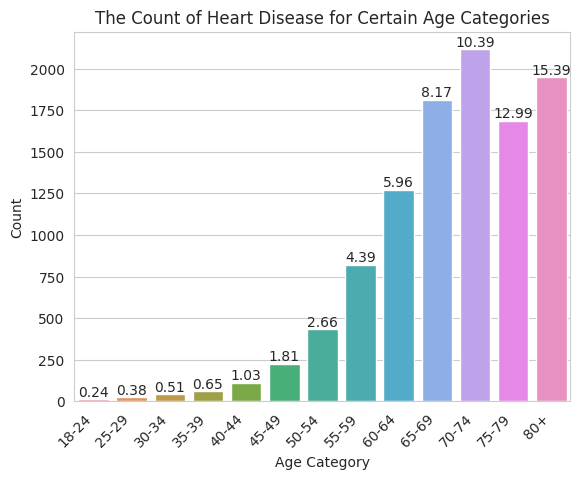

In [ ]:
df_plot = df_encoded.groupby(['Age', 'Heart_Disease']).size().reset_index().pivot(columns='Heart_Disease', index='Age', values=0)
df_plot['Percentage'] = df_plot['Yes'] / (df_plot['Yes'] + df_plot['No']) *100

ax = sns.countplot(data=df_encoded[df_encoded['Heart_Disease'] == 'Yes'].sort_values(['Age']).reset_index(drop=True), x='Age')
ax.set_title('The Count of Heart Disease for Certain Age Categories')
ax.set_xlabel('Age Category')
ax.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')

percentages = map(lambda x: round(x, 2), df_plot['Percentage'].to_list())

# Adding numbers above each bar
for p, num in zip(ax.patches, percentages):
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), num,
            ha='center', va='bottom')

# Display the plot
plt.show()

## 4.3 Heart Disease distribution by Race

Next, we wanted to plot heart disease by racial group. We see that Asians are the least likely to have heart disease and Whites and American Indian/Alaskan Native are most likely.

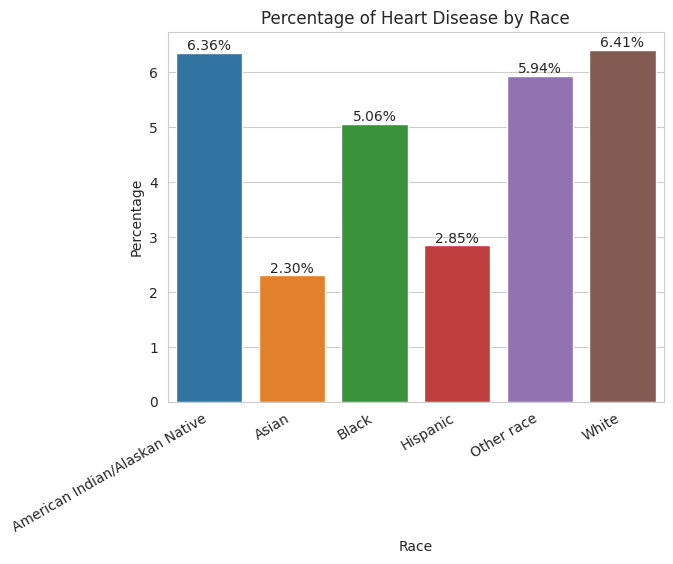

In [ ]:
df_plot = df_encoded.groupby(['Race','Heart_Disease']).size().reset_index().pivot(columns='Heart_Disease', index='Race', values=0)
df_plot['Percentage'] = df_plot['Yes'] / (df_plot['Yes'] + df_plot['No']) *100
df_plot[['Percentage']]


ax = sns.barplot(x=df_plot.index, y='Percentage', data=df_plot)
plt.xlabel('Race')
plt.ylabel('Percentage')
plt.title('Percentage of Heart Disease by Race')
plt.xticks(rotation=30, ha='right')


for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')




# Display the plot
plt.show()

## 4.4 Correlation Analysis for Numerical Variables

We next wanted to check the correlation among the numerical valuables. Since all of them < 0.5, we can safely ignore the problem of multicollinearity

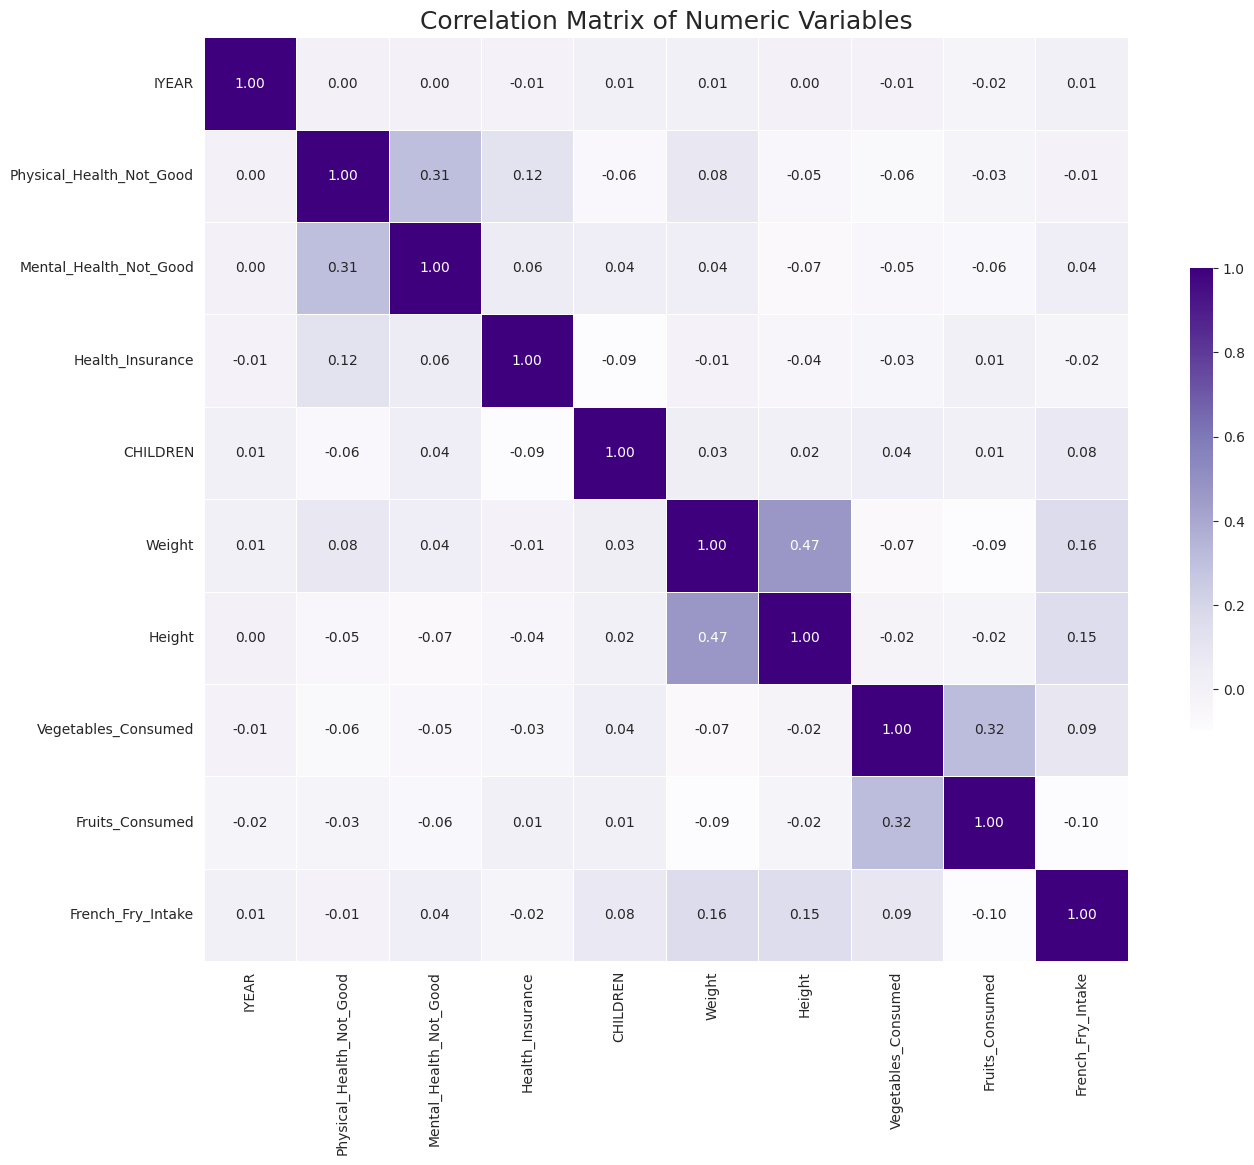

In [ ]:
# Selecting numerical variables from the dataset
numeric_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns

# Generate the correlation matrix
correlation_matrix = df_encoded[numeric_cols].corr()

# Set the aesthetic style of the plots
sns.set_style("white")

# Initialize the figure
plt.figure(figsize=(16, 12))

# Plotting the correlation matrix with light colors
sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='Purples',
            cbar_kws={"shrink": .5},
            square=True,
            linewidths=.5)

# Set the title
plt.title('Correlation Matrix of Numeric Variables', fontsize=18)

# Show the plot
plt.show()

In [ ]:
df_encoded.columns

Index(['_STATE', 'IMONTH', 'IYEAR', 'Sex', 'General_Health',
       'Physical_Health_Not_Good', 'Mental_Health_Not_Good',
       'Health_Insurance', 'Personal_Doctor', 'Last_Checkup', 'Exercise',
       'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Pulmonary_Disease',
       'Depression', 'Kidney_Disease', 'Diabetes', 'Arthritis', 'Marital',
       'Education', 'Veteran', 'Employment', 'CHILDREN', 'Income', 'Weight',
       'Height', 'Flushot', 'Metropolitan_Status', 'Urban_Status', 'Race',
       'High_BP', 'Alcohol_Consumption', 'Smoking', 'E_Smoking',
       'Vegetables_Consumed', 'Fruits_Consumed', 'High_Cholesterol', 'Asthma',
       'Age', 'French_Fry_Intake'],
      dtype='object')

## 4.5 Correlation Analysis for Categorical Variables *TODO

The dataset contains both Nominal and Ordinal features in the dataset. After extensive research, we found at that:


*   Correlation between a binary feature (Heart Disease (target variable)) and an **Ordinal** feature is found using: **Point-Biserial Correlation** (A special case of Pearson Correlation)
*   Correlation between a binary feature (Heart Disease (target variable)) and a **Nominal** feature is found using: **Cramer's Correlation**



### 4.5.1 Point-Biserial Correlation

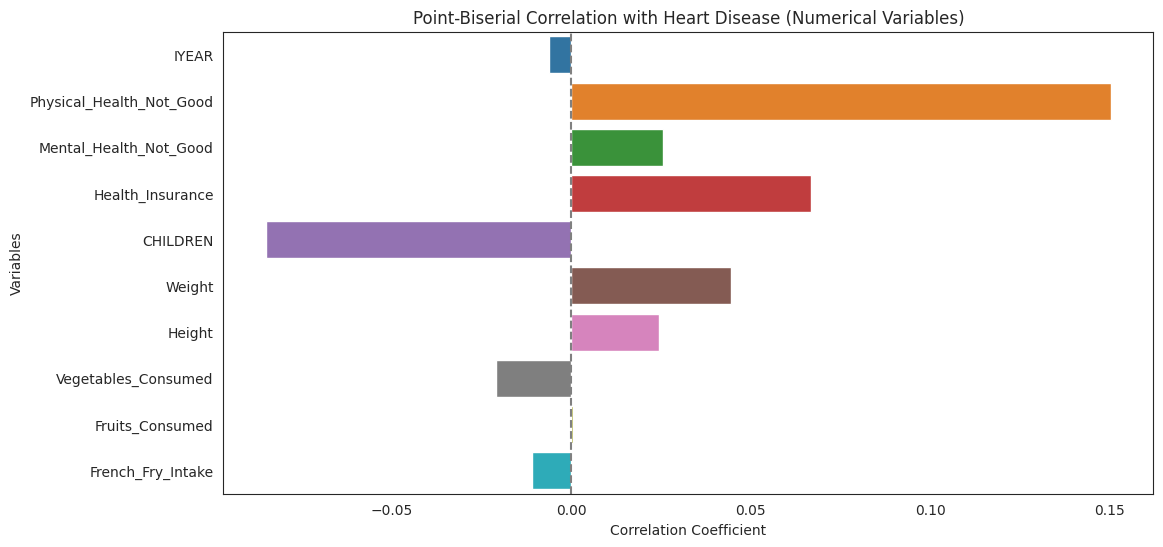

In [ ]:
# Preparing the data
temp_df_encoded = df_encoded.copy()
temp_df_encoded = temp_df_encoded.reset_index(drop = True)

# Encoding the target feature
temp_df_encoded['Heart_Disease'] = temp_df_encoded['Heart_Disease'].apply(lambda x: 1 if x == 'Yes' else 0)
temp_df_encoded.dropna(subset=['Heart_Disease'], inplace=True)

# Calculating point-biserial correlation for binary (Heart_Disease) and numerical variables
pointbiserial_correlations = {}
for column in temp_df_encoded.select_dtypes(include=['float64', 'int64']).columns:
    if column != 'Heart_Disease':
        # Ensure the column is numeric
        temp_column = pd.to_numeric(temp_df_encoded[column], errors='coerce')
        temp_df_encoded.dropna(subset=[column], inplace=True)

        correlation, p_value = pointbiserialr(temp_df_encoded['Heart_Disease'], temp_column)
        pointbiserial_correlations[column] = correlation


# Plotting point-biserial correlation coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x=list(pointbiserial_correlations.values()), y=list(pointbiserial_correlations.keys()))
plt.title('Point-Biserial Correlation with Heart Disease (Numerical Variables)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variables')
plt.axvline(x=0, color='grey', linestyle='--')
plt.show()

### 4.5.2 Cramer's Correlation

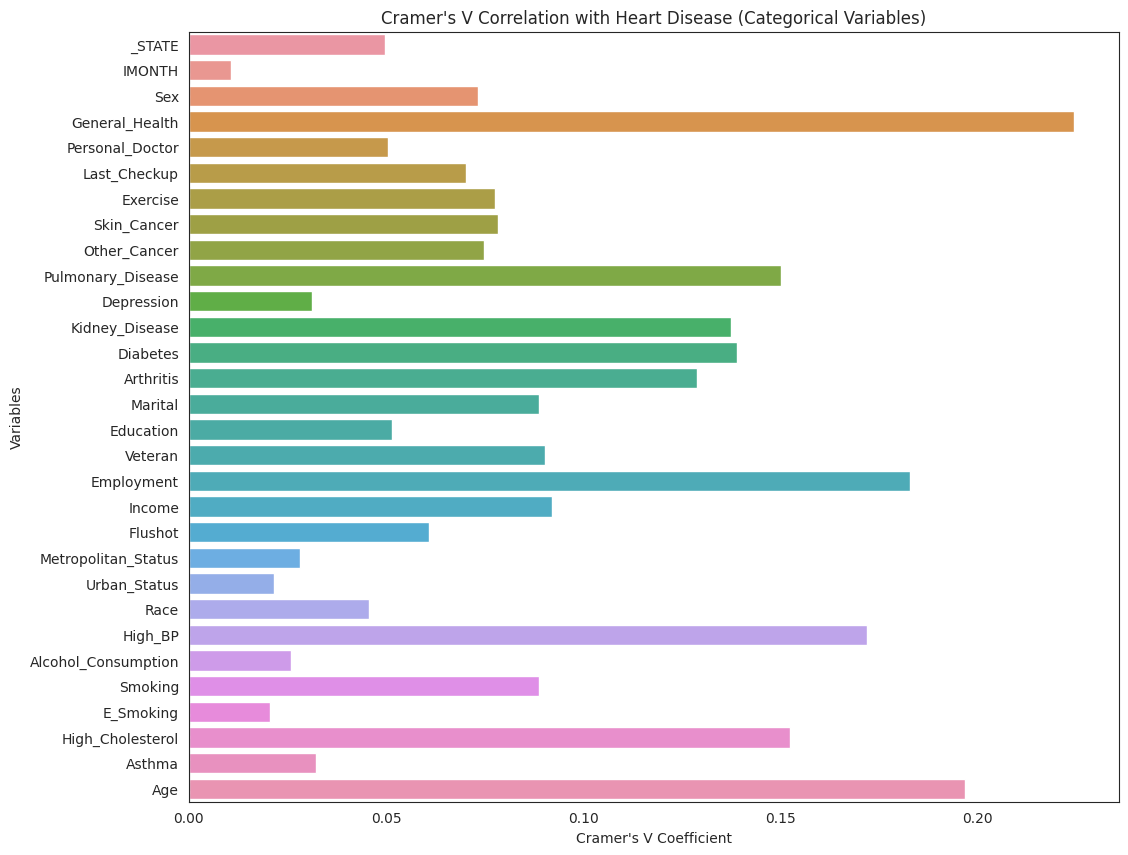

In [ ]:
# Preparing the data
temp_df_encoded = df_encoded.copy()

# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calculating Cramer's V for binary (Heart_Disease) and other categorical variables
cramers_v_correlations = {}
categorical_columns = temp_df_encoded.select_dtypes(include=['object']).columns
for column in categorical_columns:
    if column != 'Heart_Disease':
        correlation = cramers_v(temp_df_encoded['Heart_Disease'], temp_df_encoded[column])
        cramers_v_correlations[column] = correlation

# Plotting Cramer's V values for categorical variables
plt.figure(figsize=(12, 10))
sns.barplot(x=list(cramers_v_correlations.values()), y=list(cramers_v_correlations.keys()))
plt.title('Cramer\'s V Correlation with Heart Disease (Categorical Variables)')
plt.xlabel('Cramer\'s V Coefficient')
plt.ylabel('Variables')
plt.axvline(x=0, color='grey', linestyle='--')
plt.show()

## 4.6 Geospatial distribution of Heart Disease *TODO

We wanted to see distribution of heart disease across each state to see if heart disease affects certain parts of the US more than others.

### 4.6.1 Heart Disease Ratio

From the ratio of heart disease by state, we see Arkansas has the highest ratio of people with heart disease.

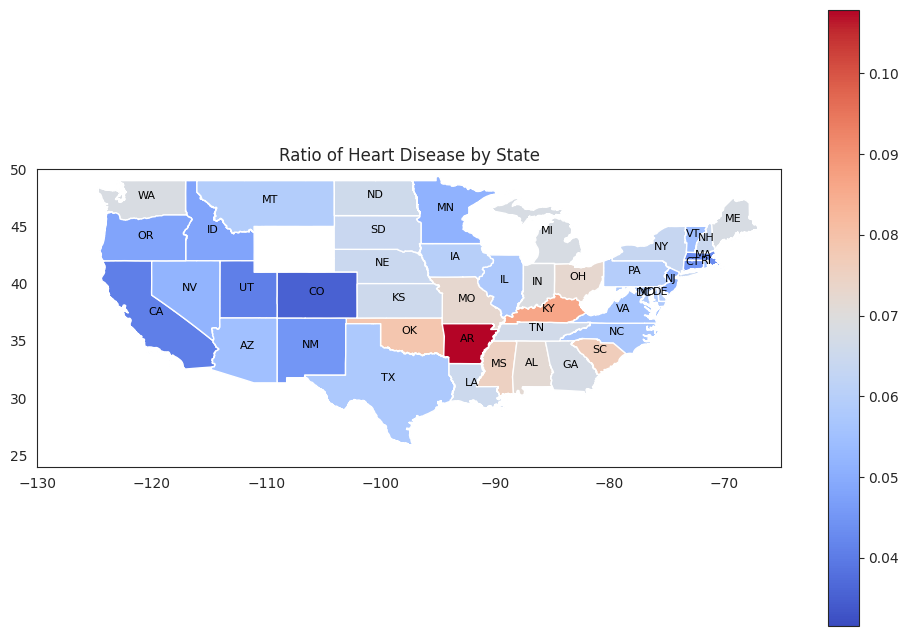

In [ ]:
# Calculating the ratio of Heart_Diseas = Yes vs Total Members in the Survey
ratios = df_encoded.groupby('_STATE')['Heart_Disease'].value_counts(normalize=True).unstack().fillna(0)
ratios['ratio'] = ratios['Yes'] / (ratios['No'] + ratios['Yes'])

# Load the shapefile
gdf = gpd.read_file('/content/cb_2018_us_state_500k.shp')

# Merge the GeoDataFrame with the ratios DataFrame
gdf = gdf.merge(ratios, left_on='NAME', right_index=True)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust figsize to get a clear view
gdf.plot(column='ratio', ax=ax, legend=True, cmap='coolwarm', aspect='equal')

# Annotate the states
for idx, row in gdf.iterrows():
    plt.annotate(text=row['STUSPS'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontweight='light', fontsize=8, color='black')

# Optionally, set the x and y axis limits to frame the continental US more tightly
ax.set_xlim([-130, -65])
ax.set_ylim([24, 50])

ax.set_title('Ratio of Heart Disease by State')
plt.show()

### 4.6.2 Heart Disease Count

Now, we will look at the raw counts instead. In this case, NY has the highest counts of people with heart disease. However, it is important to keep in mind this result can be skewed by the number of people surveyed in each state.


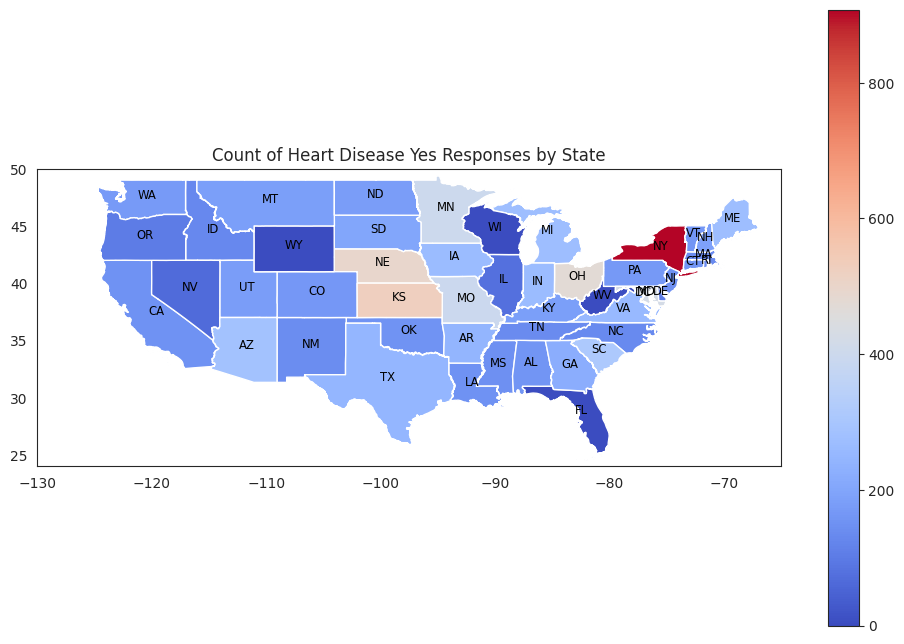

In [ ]:
# Calculating the count of Heart_Diseas = Yes
counts = df_encoded[df_encoded['Heart_Disease'] == 'Yes'].groupby('_STATE')['Heart_Disease'].count()

# Load the shapefile
gdf = gpd.read_file('/content/cb_2018_us_state_500k.shp')

# Merge the GeoDataFrame with the counts DataFrame
gdf = gdf.merge(counts, left_on='NAME', right_index=True, how='left').fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust figsize to get a clear view
gdf.plot(column='Heart_Disease', ax=ax, legend=True, cmap='coolwarm', aspect='equal')

# Annotate the states
for idx, row in gdf.iterrows():
    plt.annotate(text=row['STUSPS'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontweight='light', fontsize='small', color='black')

# Optionally, set the x and y axis limits to frame the continental US more tightly
ax.set_xlim([-130, -65])
ax.set_ylim([24, 50])

ax.set_title('Count of Heart Disease Yes Responses by State')
plt.show()

In [ ]:
df_encoded.columns

Index(['_STATE', 'IMONTH', 'IYEAR', 'Sex', 'General_Health',
       'Physical_Health_Not_Good', 'Mental_Health_Not_Good',
       'Health_Insurance', 'Personal_Doctor', 'Last_Checkup', 'Exercise',
       'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Pulmonary_Disease',
       'Depression', 'Kidney_Disease', 'Diabetes', 'Arthritis', 'Marital',
       'Education', 'Veteran', 'Employment', 'CHILDREN', 'Income', 'Weight',
       'Height', 'Flushot', 'Metropolitan_Status', 'Urban_Status', 'Race',
       'High_BP', 'Alcohol_Consumption', 'Smoking', 'E_Smoking',
       'Vegetables_Consumed', 'Fruits_Consumed', 'High_Cholesterol', 'Asthma',
       'Age', 'French_Fry_Intake'],
      dtype='object')

In [ ]:
# from sklearn.cluster import KMeans
# temp_df_encoded = df_encoded
# categorical_cols = temp_df_encoded.select_dtypes(include=['object', 'category']).columns
# label_encoders = {}
# for col in categorical_cols:
#     le = LabelEncoder()
#     temp_df_encoded[col] = le.fit_transform(temp_df_encoded[col])
#     label_encoders[col] = le

# # Standardize the features
# scaler = StandardScaler()
# X = scaler.fit_transform(temp_df_encoded.drop('Heart_Disease', axis=1))

# # Perform K-Means Clustering
# kmeans = KMeans(n_clusters=2, random_state=0)
# kmeans_clusters = kmeans.fit_predict(X)

# # Add the cluster information to the dataframe
# temp_df_encoded['KMeans_Cluster'] = kmeans_clusters

# # Visualizing the clusters for the chosen set of features
# # Choosing 2 clusters because Heart_Disease is a binary classification problem
# sns.pairplot(temp_df_encoded, vars=['Age', 'High_Cholesterol', 'High_BP', 'Smoking', 'E_Smoking'],
#              hue='KMeans_Cluster', plot_kws={'alpha': 0.5}, height=4, aspect=1)
# plt.legend(title='Cluster', loc='upper right', labels=['Cluster 0', 'Cluster 1'])
# plt.show()

## Metropolitan and Urban status

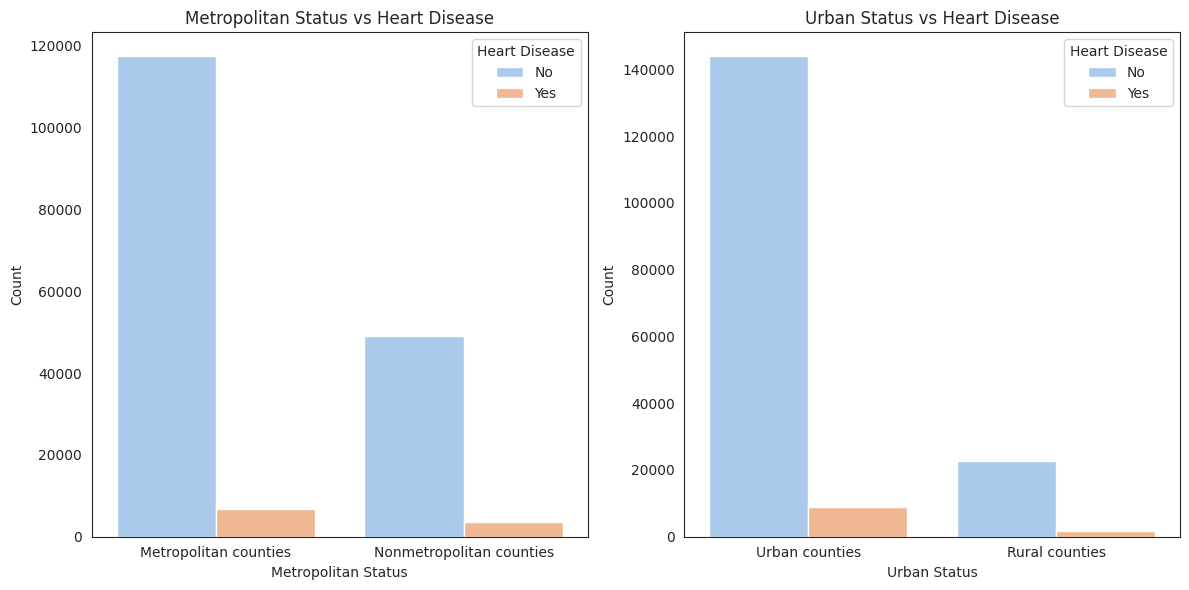

In [ ]:
# Creating the visualization
plt.figure(figsize=(12, 6))

# Plotting Metropolitan_Status vs Heart_Disease
plt.subplot(1, 2, 1)
sns.countplot(x='Metropolitan_Status', hue='Heart_Disease', data=df_encoded, palette='pastel')
plt.title('Metropolitan Status vs Heart Disease')
plt.xlabel('Metropolitan Status')
plt.ylabel('Count')
plt.legend(title='Heart Disease')

# Plotting Urban_Status vs Heart_Disease
plt.subplot(1, 2, 2)
sns.countplot(x='Urban_Status', hue='Heart_Disease', data=df_encoded, palette='pastel')
plt.title('Urban Status vs Heart Disease')
plt.xlabel('Urban Status')
plt.ylabel('Count')
plt.legend(title='Heart Disease')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

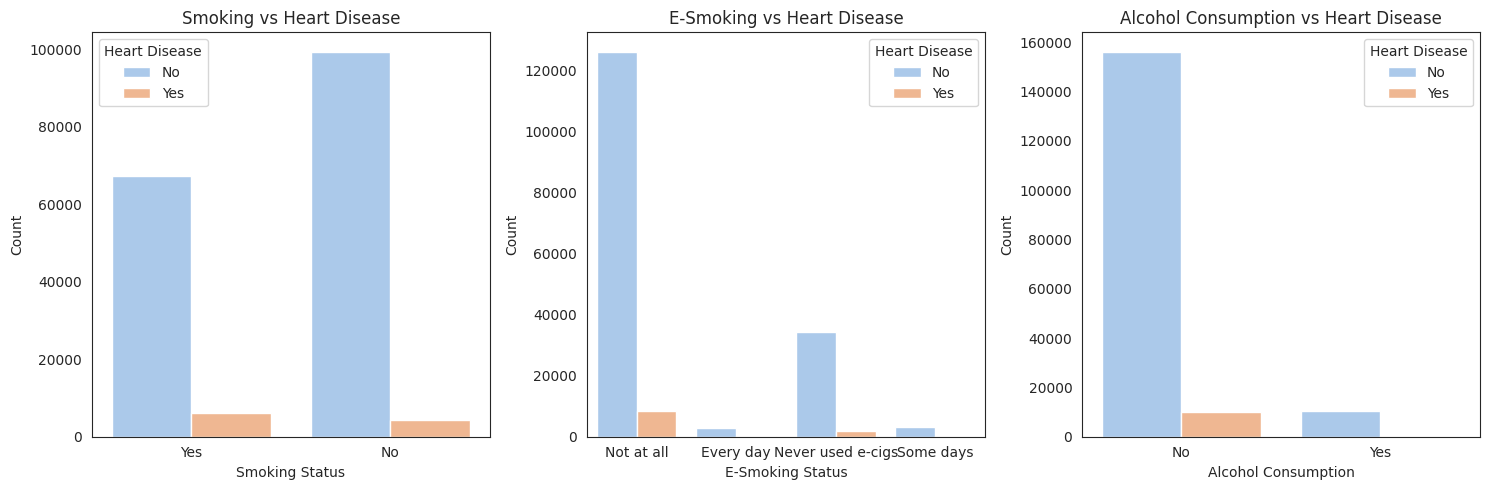

In [ ]:
# Creating the visualization
plt.figure(figsize=(15, 5))

# Plotting Smoking vs Heart_Disease
plt.subplot(1, 3, 1)
sns.countplot(x='Smoking', hue='Heart_Disease', data=df_encoded, palette='pastel')
plt.title('Smoking vs Heart Disease')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.legend(title='Heart Disease')

# Plotting E_Smoking vs Heart_Disease
plt.subplot(1, 3, 2)
sns.countplot(x='E_Smoking', hue='Heart_Disease', data=df_encoded, palette='pastel')
plt.title('E-Smoking vs Heart Disease')
plt.xlabel('E-Smoking Status')
plt.ylabel('Count')
plt.legend(title='Heart Disease')

# Plotting Alcohol_Consumption vs Heart_Disease
plt.subplot(1, 3, 3)
sns.countplot(x='Alcohol_Consumption', hue='Heart_Disease', data=df_encoded, palette='pastel')
plt.title('Alcohol Consumption vs Heart Disease')
plt.xlabel('Alcohol Consumption')
plt.ylabel('Count')
plt.legend(title='Heart Disease')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
df_encoded

,_STATE,IMONTH,IYEAR,Sex,General_Health,Physical_Health_Not_Good,Mental_Health_Not_Good,Health_Insurance,Personal_Doctor,Last_Checkup,...,High_BP,Alcohol_Consumption,Smoking,E_Smoking,Vegetables_Consumed,Fruits_Consumed,High_Cholesterol,Asthma,Age,French_Fry_Intake
0,Alabama,January,2021,Female,Poor,20.0,10.0,3.0,Yes,Within past 2 years,...,No,No,Yes,Not at all,214.0,100.0,Yes,Yes,70-74,43.0
2,Alabama,January,2021,Female,Very Good,0.0,0.0,2.0,Yes,Within Past Year,...,Yes,No,No,Not at all,71.0,100.0,No,No,70-74,14.0
3,Alabama,January,2021,Female,Very Good,0.0,10.0,2.0,Yes,Within Past Year,...,Yes,No,No,Not at all,165.0,114.0,Yes,No,60-64,57.0
5,Alabama,January,2021,Male,Good,0.0,0.0,3.0,Yes,Within Past Year,...,No,No,Yes,Not at all,42.0,29.0,No,No,80+,0.0
9,Alabama,February,2021,Female,Good,25.0,5.0,3.0,Yes,Within Past Year,...,Yes,No,Yes,Not at all,158.0,100.0,No,No,65-69,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406283,Washington,February,2021,Female,Very Good,0.0,2.0,1.0,Yes,Within Past Year,...,No,Yes,No,Not at all,39.0,29.0,No,No,55-59,3.0
406284,Washington,February,2021,Male,Very Good,4.0,5.0,3.0,Yes,Within Past Year,...,Yes,No,Yes,Not at all,167.0,23.0,Yes,Yes,50-54,40.0
406286,Washington,February,2021,Female,Good,2.0,3.0,1.0,Yes,Within Past Year,...,No,Yes,No,Not at all,129.0,43.0,Yes,No,25-29,29.0
406288,Washington,February,2021,Male,Excellent,0.0,4.0,1.0,Yes,Within past 5 years,...,No,No,No,Not at all,72.0,29.0,Yes,No,45-49,7.0


## Air Quality Index Map

https://worldpopulationreview.com/state-rankings/air-quality-by-state


In [ ]:
air_quality_index[air_quality_index['state'] == 'Florida']['AirQualityIndex'][9]

38.9

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Index(['NAME', 'AirQualityIndex', 'ratio'], dtype='object')


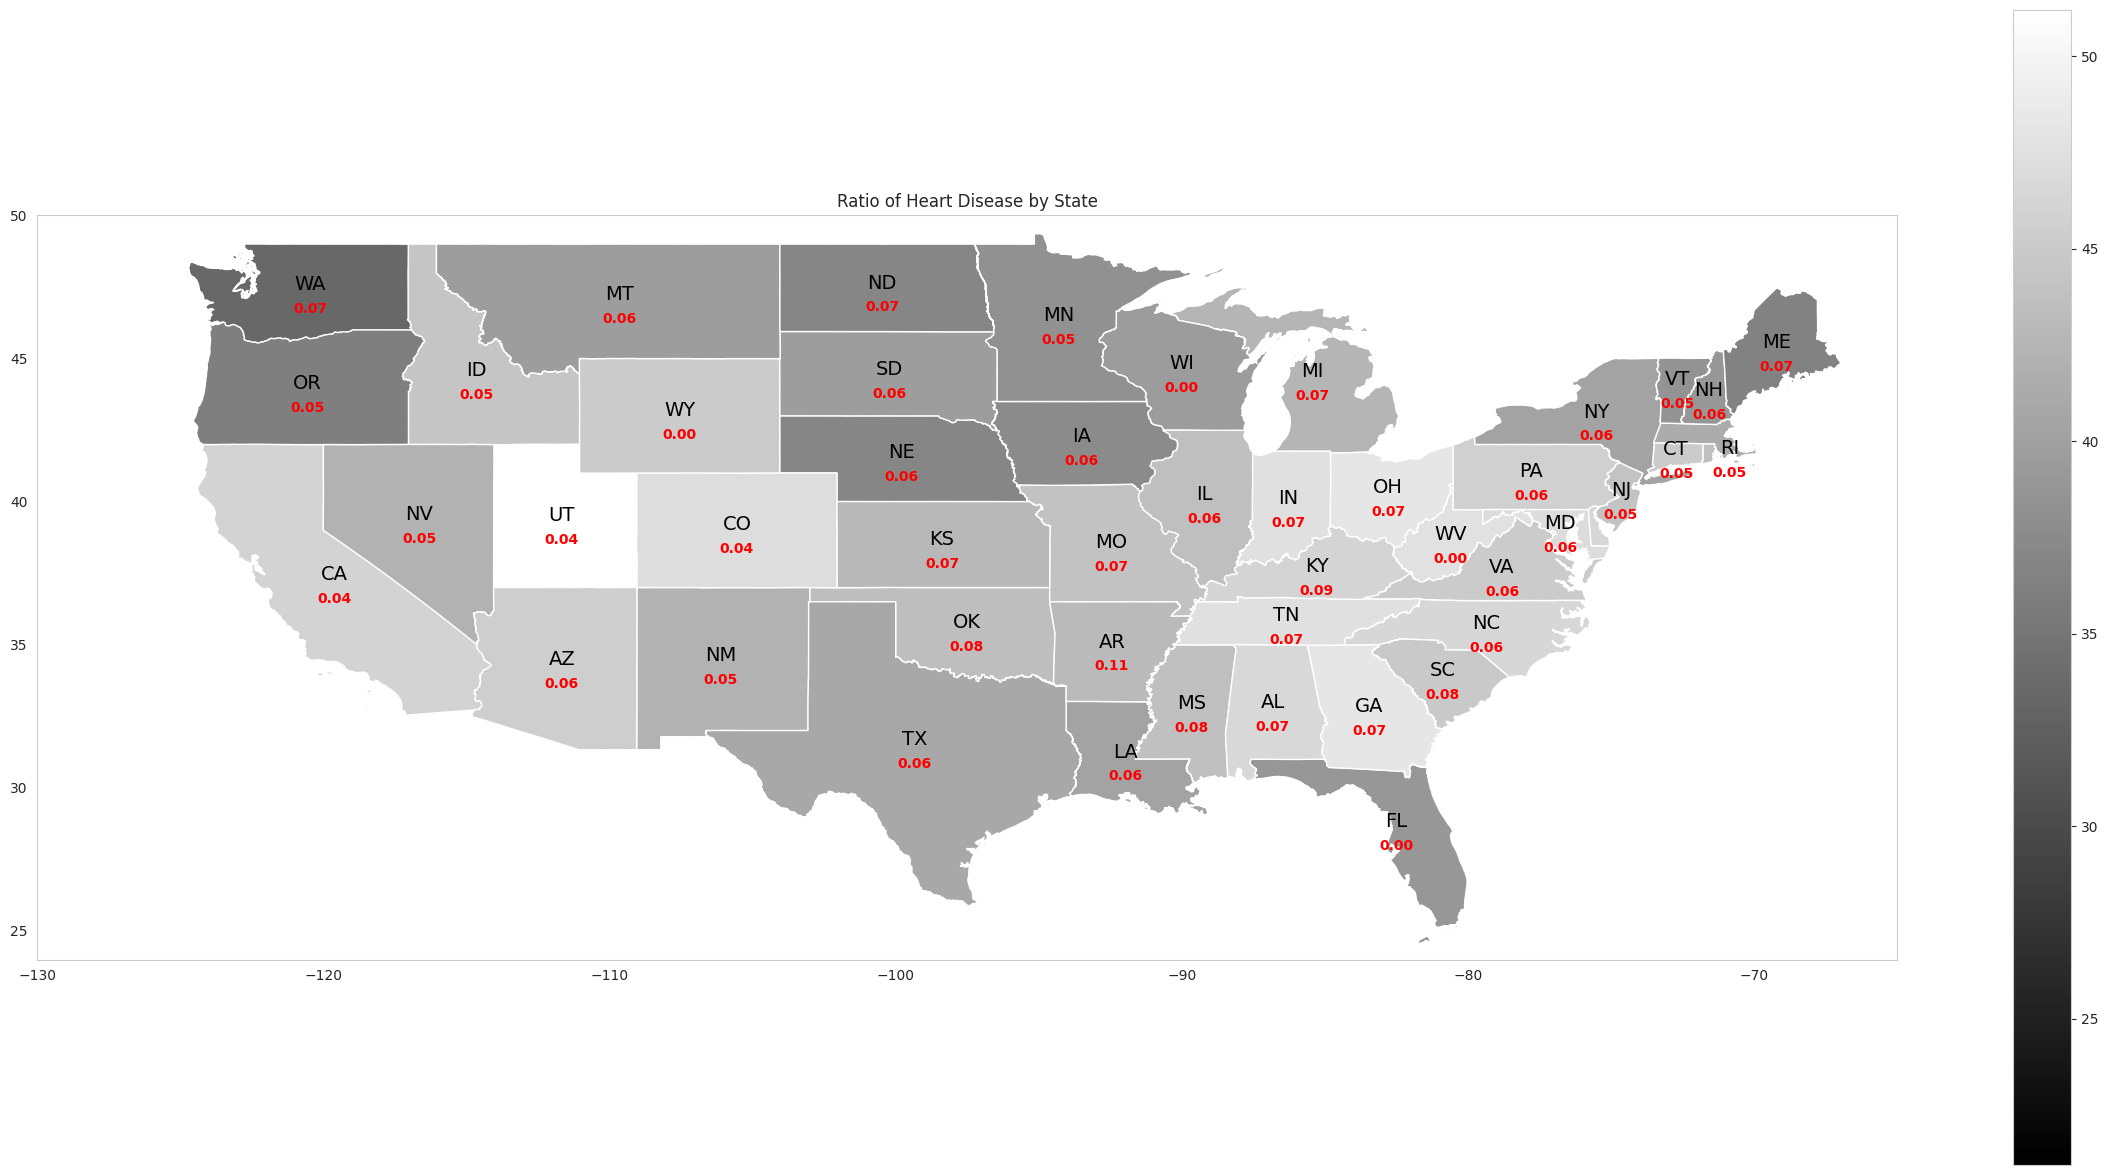

In [ ]:
air_quality_index = pd.read_csv('/content/air-quality-by-state.csv')
air_quality_index = air_quality_index[:-1]
df_encoded_air = df_encoded
df_encoded_air = pd.merge(df_encoded_air[['_STATE', 'Heart_Disease']], air_quality_index[['state', 'AirQualityIndex']], left_on = '_STATE',
                          right_on = 'state', how = 'right')
ratios = df_encoded_air.groupby('state')['Heart_Disease'].value_counts().unstack().fillna(0)
ratios['ratio'] = ratios['Yes'] / (ratios['No'] + ratios['Yes'])
ratios = ratios.reset_index()
df_encoded_air = pd.merge(df_encoded_air, ratios, on = 'state', how = 'inner')
df_encoded_air = df_encoded_air.drop(['_STATE', 'Heart_Disease', 'No', 'Yes'], axis = 1)
df_encoded_air = df_encoded_air.groupby('state').mean()

# Adding the missing States

new_data_air = pd.DataFrame({
    'AirQualityIndex': [38.9,39.5,45.0,47.6],
    'ratio': [0, 0, 0, 0]
}, index=['Florida', 'Wisconsin', 'Wyoming', 'West Virginia'])

# Append the new row to the DataFrame
df_encoded_air = df_encoded_air.append(new_data_air)

df_encoded_air.reset_index(inplace = True)
df_encoded_air.rename(columns={'index':"NAME"}, inplace = True)

print(df_encoded_air.columns)
gdf = gdf.merge(df_encoded_air, how='inner', on='NAME')


# Visualizing a 3d plot
#plot state heart disease heatmap
fig, ax = plt.subplots(figsize=(30, 15))  # Adjust figsize to get a clear view
ax.grid(False)
gdf.plot(column='AirQualityIndex', ax=ax, legend=True, cmap='gist_gray', aspect='equal')

#add state abbreviations (except for DC)
for idx, row in gdf.iterrows():
  if row['STUSPS']=='DC':
    pass
  elif row['STUSPS'] == 'DE' or row['STUSPS'] == 'MA':
    pass

  elif row['STUSPS'] == 'RI':
    plt.annotate(text=row['STUSPS'], xy=(row['geometry'].centroid.x+0.7, row['geometry'].centroid.y),
                 horizontalalignment='center', fontweight='light', fontsize=14, color='black')

    # Add data from the 'ratio' column
    plt.annotate(text=f"{row['ratio']:.2f}",
                  xy=(row['geometry'].centroid.x+0.7, row['geometry'].centroid.y - 0.8),
                  horizontalalignment='center', fontweight='bold', fontsize=10, color='red')

  else:
    plt.annotate(text=row['STUSPS'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontweight='light', fontsize=14, color='black')

    # Add data from the 'ratio' column
    plt.annotate(text=f"{row['ratio']:.2f}",
                  xy=(row['geometry'].centroid.x, row['geometry'].centroid.y - 0.8),
                  horizontalalignment='center', fontweight='bold', fontsize=10, color='red')

ax.set_xlim([-130, -65])
ax.set_ylim([24, 50])
ax.set_title('Ratio of Heart Disease by State')
plt.show()

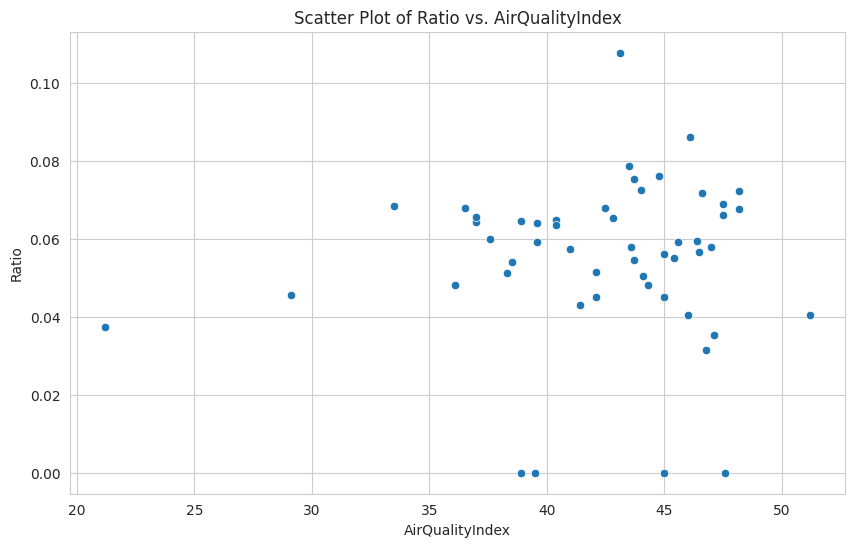

Pearson Correlation Coefficient: 0.06389312151286393


In [ ]:
# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_encoded_air, x='AirQualityIndex', y='ratio')
plt.title('Scatter Plot of Ratio vs. AirQualityIndex')
plt.xlabel('AirQualityIndex')
plt.ylabel('Ratio')
plt.show()

# Calculate Pearson Correlation Coefficient
correlation = df_encoded_air['AirQualityIndex'].corr(df_encoded_air['ratio'])
print(f"Pearson Correlation Coefficient: {correlation}")

,AirQualityIndex,No,Yes,ratio
state,,,,
Alabama,46.6,2043.0,158.0,0.071786
Alaska,29.1,2254.0,108.0,0.045724
Arizona,45.4,4889.0,285.0,0.055083
Arkansas,43.1,2002.0,242.0,0.107843
California,46.0,3520.0,149.0,0.040611
Colorado,47.1,4478.0,164.0,0.035330
Connecticut,45.0,3369.0,159.0,0.045068
Delaware,46.4,1610.0,102.0,0.059579
District of Columbia,46.8,1350.0,44.0,0.031564


In [ ]:


#rename column and add 0 for missing state
row1 = pd.DataFrame({'state':['Florida'],
                     'ratio':[0]
                     })
row2 = pd.DataFrame({'state':['Wisconsin'],
                     'ratio':[0]
                     })
row3 = pd.DataFrame({'state':['West Virginia'],
                     'ratio':[0]
                     })
row4 = pd.DataFrame({'state':['Wyoming'],
                     'ratio':[0]
                     })
df_encoded_air = pd.concat([df_encoded_air, row1, row2, row3, row4], ignore_index=True)
df_encoded_air
#round to two decimal places
# df_encoded_air[['No', 'Yes', 'ratio']] = df_encoded_air[['No', 'Yes', 'ratio']].apply(lambda x: np.round(x, 2))

,_STATE,Heart_Disease,state,AirQualityIndex,ratio
0,Alabama,No,Alabama,46.6,NaN
1,Alabama,Yes,Alabama,46.6,NaN
2,Alabama,No,Alabama,46.6,NaN
3,Alabama,No,Alabama,46.6,NaN
4,Alabama,No,Alabama,46.6,NaN
...,...,...,...,...,...
177138,NaN,NaN,Wyoming,45.0,NaN
177139,NaN,NaN,Florida,NaN,0.0
177140,NaN,NaN,Wisconsin,NaN,0.0
177141,NaN,NaN,West Virginia,NaN,0.0


In [ ]:
df_encoded_air

,_STATE,Heart_Disease,state,AirQualityIndex,ratio,NAME,No,Yes
0,Alabama,No,Alabama,46.6,NaN,NaN,NaN,NaN
1,Alabama,Yes,Alabama,46.6,NaN,NaN,NaN,NaN
2,Alabama,No,Alabama,46.6,NaN,NaN,NaN,NaN
3,Alabama,No,Alabama,46.6,NaN,NaN,NaN,NaN
4,Alabama,No,Alabama,46.6,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
177138,NaN,NaN,Wyoming,45.0,NaN,NaN,NaN,NaN
177139,NaN,NaN,NaN,NaN,0.0,Florida,0.0,0.0
177140,NaN,NaN,NaN,NaN,0.0,Wisconsin,0.0,0.0
177141,NaN,NaN,NaN,NaN,0.0,West Virginia,0.0,0.0


Series([], dtype: int64)

In [ ]:
df_encoded_air.columns

Index(['_STATE', 'Heart_Disease', 'state', 'AirQualityIndex'], dtype='object')

In [ ]:
#plot state heart disease heatmap
fig, ax = plt.subplots(figsize=(22, 8))  # Adjust figsize to get a clear view
gdf = gpd.read_file('/content/cb_2018_us_state_500k.shp')
#merge the GeoDataFrame with the ratios DataFrame
df_encoded_air = df_encoded_air.rename(columns={"state":"NAME"})
gdf = gdf.merge(df_encoded_air, how='inner', on='NAME')


In [ ]:
gdf.plot(column='AirQualityIndex', ax=ax, legend=True, cmap='Blues', aspect='equal')

#add state abbreviations (except for DC)
# for idx, row in gdf.iterrows():
#   if row['STUSPS']=='DC':
#     pass
#   else:
#     plt.annotate(text=row['STUSPS'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
#                  horizontalalignment='center', fontweight='light', fontsize=10, color='black')
plt.annotate(text=row['STUSPS'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontweight='light', fontsize=10, color='black')
ax.set_xlim([-130, -65])
ax.set_ylim([24, 50])

ax.set_title('Ratio of Heart Disease by State')
plt.show()

In [ ]:
df_encoded_air.isna().sum()

_STATE             4
Heart_Disease      4
state              0
AirQualityIndex    0
dtype: int64

## 4.7 Findings, Thoughts and Observations

*   The Variables Age, and General Health show a moderate correlation with Heart_Disease.
*   A lot of the features have almost no correlation with the target variable.
*   The ones that are the least correalated can be removed during feature selection if we want to reduce the number of dimensions.

# SECTION V: BASELINE MODEL


Moving onto our baseline model, we select our target variable to be heart disease.

In [ ]:
# Preparing the data

df_encoded_final = df_encoded.copy()
target_var = ['Heart_Disease']

## 5.1 Label Encoding the Ordinal Variables

To prepare our dataset for the baseline model, we label encode the following features: 'General_Health', 'Last_Checkup', 'E_Smoking', 'Age', 'Education', and 'Income'.

In [ ]:
# Initialize LabelEncoder
le = LabelEncoder()

ordinal_vars = ['General_Health', 'Last_Checkup', 'E_Smoking', 'Age', 'Education', 'Income']

# Label Encoding for Ordinal Variables

df_encoded_final = to_text_map(df_encoded_final, 'General_Health', {'Excellent':1, 'Very Good':2, 'Good':3, 'Fair':4, 'Poor':5})
df_encoded_final = to_text_map(df_encoded_final, 'Last_Checkup', {'Within Past Year':1, 'Within past 2 years':2, 'Within past 5 years':3,
                                                  '5 or more years ago':4, 'Never':5})
df_encoded_final = to_text_map(df_encoded_final, 'Income',
            {'Less than $10,000':1, '$10,000 - $15,000':2, '$15,000 - $20,000':3, '$20,000 - $25,000':4, '$25,000 - $35,000':5,
             '$35,000 - $50,000':6, '$50,000 - $75,000':7, '$75,000 - $100,000':8, '$100,000 - $150,000':9, '$150,000 - $200,000':10,
             '$200,000 or more':11})
df_encoded_final = to_text_map(df_encoded_final, 'E_Smoking', {'Never used e-cigs':0, 'Not at all':1, 'Some days':2, 'Every day':3})

df_encoded_final = to_text_map(df_encoded_final, 'Age', {'18-24':1, '25-29':2, '30-34':3, '35-39':4, '40-44':5,
                                                  '45-49':6, '50-54':7, '55-59':8, '60-64':9, '65-69':10,
                                                  '70-74':11, '75-79':12, '80+':13})
df_encoded_final = to_text_map(df_encoded_final, 'Education', {'None':1, 'Elementary':2, 'Some High School':3, 'High School Graduate':4, 'Some College':5, 'College Graduate':6})


## 5.2 One Hot Encoding the Nominal Variables

One hot encoding was done for the following features: 'Health Insurance', 'Personal_Doctor', 'Flushot' , 'Metropolitan_Status', 'Urban_Status', 'Race', 'High_BP', 'Alcohol_Consumption', 'Smoking', 'High_Cholesterol', 'Asthma', 'Exercise', 'Skin_Cancer', 'Other_Cancer', 'Pulmonary_Disease', 'Depression', 'Kidney_Disease', 'Diabetes', 'Arthritis', 'Marital', 'Veteran', 'Employment', and 'Sex'.

In [ ]:
nominal_vars = ['Health Insurance', 'Personal_Doctor', 'Flushot', 'Metropolitan_Status', 'Urban_Status', 'Race', 'High_BP', 'Alcohol_Consumption',
                'Smoking', 'High_Cholesterol', 'Asthma', 'Exercise', 'Skin_Cancer', 'Other_Cancer',
                'Pulmonary_Disease', 'Depression', 'Kidney_Disease', 'Diabetes', 'Arthritis', 'Marital', 'Veteran', 'Employment', 'Sex']

# One-Hot Encoding for Nominal Variables
df_encoded_final = pd.get_dummies(df_encoded_final, columns=nominal_vars, drop_first=True)

# View the encoded dataset
df_encoded_final.head()

,_STATE,IMONTH,IYEAR,General_Health,Physical Health Not Good,Mental Health Not Good,Last_Checkup,Heart_Disease,Education,CHILDREN,...,Marital_Widowed,Veteran_Yes,Employment_Homemaker,Employment_Out of work for 1 year or more,Employment_Out of work for < 1 year,Employment_Retired,Employment_Self-employed,Employment_Student,Employment_Unable to Work,Sex_Male
0,Alabama,January,2021,5,20.0,10.0,2,No,4,0.0,...,0,0,0,0,0,1,0,0,0,0
2,Alabama,January,2021,2,0.0,0.0,1,Yes,4,0.0,...,1,0,0,0,0,1,0,0,0,0
3,Alabama,January,2021,2,0.0,10.0,1,No,4,0.0,...,0,0,0,0,0,1,0,0,0,0
5,Alabama,January,2021,3,0.0,0.0,1,No,5,0.0,...,0,0,0,0,0,1,0,0,0,1
9,Alabama,February,2021,3,25.0,5.0,1,No,4,0.0,...,0,0,0,0,0,1,0,0,0,0


## 5.3 Preparing the data

For our modeling, we exclude state, month, and year. We then split the data into training and testing sets with a 70/30 split. We also split the data by stratified sampling to help deal with the potential problem of imbalanced datasets.

In [ ]:
# Dropping Irrelevant features
df_encoded_final.drop(['_STATE', 'IMONTH', 'IYEAR'], axis = 1, inplace=True)

# Seperating the data
X = df_encoded_final.drop(['Heart_Disease'], axis = 1)
y = df_encoded_final['Heart_Disease']

# Random Splitting of the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Stratified Splitting of the data into training and testing
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## 5.4 Simple Logistic Regression
(With and Without Stratified Splitting)

We chose logistic regression as our baseline model since our target variable is categorical and is relatively simple.

In [ ]:
# Simple Random Splitting
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Stratified Splitting
model = LogisticRegression()
model.fit(X_train_strat, y_train_strat)
y_pred_strat = model.predict(X_test_strat)

print("Accuracy:", accuracy_score(y_test_strat, y_pred_strat))
print("\nClassification Report:\n", classification_report(y_test_strat, y_pred_strat))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 0.9425990905228707

Classification Report:
               precision    recall  f1-score   support

          No       0.94      1.00      0.97     59931
         Yes       0.28      0.00      0.01      3622

    accuracy                           0.94     63553
   macro avg       0.61      0.50      0.49     63553
weighted avg       0.91      0.94      0.92     63553



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 0.9428193791009079

Classification Report:
               precision    recall  f1-score   support

          No       0.94      1.00      0.97     59954
         Yes       0.27      0.01      0.01      3599

    accuracy                           0.94     63553
   macro avg       0.61      0.50      0.49     63553
weighted avg       0.91      0.94      0.92     63553



While the overall accuracy is very good (94%), the model does not do well at predicting positive cases of heart disease. We believe this could be because of the imbalance in the dataset. There are significantly more No's than Yes's (about 20X more).

## 5.5 K Fold cross validation

We then redo the logistic regression with K Folds cross validation to better assess the robustness of the baseline model.

In [ ]:
kfold = KFold(n_splits = 5)
accuracy = []

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

for train_idx, test_idx in kfold.split(X):
  X_train, X_test = X[X.index.isin(train_idx)], X[X.index.isin(test_idx)]
  y_train, y_test = y[train_idx], y[test_idx]

  reg = LogisticRegression()
  reg_fit = reg.fit(X_train, y_train)

  accuracy.append(reg_fit.score(X_test, y_test))
  y_pred = reg_fit.predict(X_test)
  print("\nClassification Report:\n", classification_report(y_test, y_pred))

print(accuracy)
print(np.mean(accuracy))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Classification Report:
               precision    recall  f1-score   support

          No       0.95      1.00      0.97     40251
         Yes       0.15      0.00      0.00      2118

    accuracy                           0.95     42369
   macro avg       0.55      0.50      0.49     42369
weighted avg       0.91      0.95      0.93     42369



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Classification Report:
               precision    recall  f1-score   support

          No       0.94      1.00      0.97     39829
         Yes       0.32      0.00      0.01      2540

    accuracy                           0.94     42369
   macro avg       0.63      0.50      0.49     42369
weighted avg       0.90      0.94      0.91     42369



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Classification Report:
               precision    recall  f1-score   support

          No       0.94      1.00      0.97     39913
         Yes       0.33      0.01      0.01      2455

    accuracy                           0.94     42368
   macro avg       0.64      0.50      0.49     42368
weighted avg       0.91      0.94      0.91     42368



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Classification Report:
               precision    recall  f1-score   support

          No       0.94      1.00      0.97     39828
         Yes       0.27      0.00      0.01      2540

    accuracy                           0.94     42368
   macro avg       0.60      0.50      0.49     42368
weighted avg       0.90      0.94      0.91     42368



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Classification Report:
               precision    recall  f1-score   support

          No       0.94      1.00      0.97     40024
         Yes       0.27      0.00      0.00      2344

    accuracy                           0.94     42368
   macro avg       0.61      0.50      0.49     42368
weighted avg       0.91      0.94      0.92     42368

[0.9494677712478463, 0.9398380891689678, 0.9417012839879154, 0.9395534365558912, 0.9445572129909365]
0.9430235587903114


## 5.6 Findings, Thoughts and Observations

*   Precision, Recall, F1 Score are very low for 'yes' and very high for 'no'. This indicates the model is biased toward 'no' class.
*   The overall high accuracy (94.29%) is misleading in this context because it doesn't reflect the poor performance on the "Yes" class.
*   The model is very biased towards the 'No' class due to the extensive imbalance in the dataset.
*   The following section deals with further processing the data to obtain better results for Modeling



# SECTION VI: DATA PREPARATION

## 6.1 Scaling

If you recall from the distribution plots shown in EDA, we suggested that scaling the data may be necessary.

In [ ]:
# Preparing the Data
df_standardized = df_encoded_final
target = df_standardized['Heart_Disease']
df_standardized = df_standardized.drop(['Heart_Disease'], axis = 1)
X = df_standardized
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initializing the Scaler
scaler = StandardScaler()

# Scaling the training and testing sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 6.2 Dimensionality Reduction

### 6.2.1 Applying PCA

Since the data is relatively large and has high dimensionality, we can try to reduce the amount of features using principle component analysis (PCA).

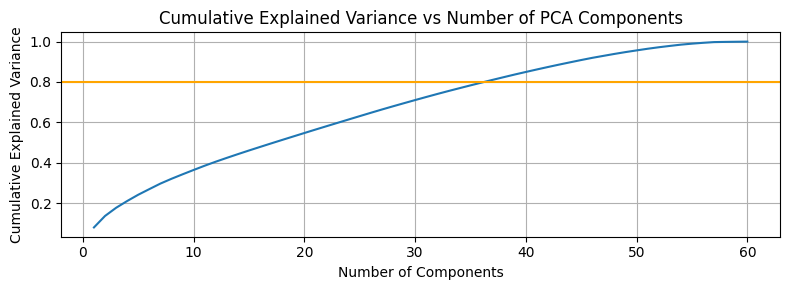

In [ ]:
pca_raw = PCA()
pca_raw.fit(X_train_scaled)

explained_variance_ratios = pca_raw.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)

xvals = list(range(1,61))

plt.figure(figsize=(8,3))
plt.plot(xvals, cum_evr)
plt.axhline(y=.8, color ='orange')


plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance vs Number of PCA Components")

plt.grid(True)
plt.tight_layout()
plt.show()

### 6.2.2 Choosing the Components explaining 80% of the variance in the data

From the plot in the previous section, 40 components takes into account about 80% of the variance in the data.

In [ ]:
pca_40 = PCA(n_components = 40, svd_solver='randomized', random_state = 42)
X_train_40 = pca_40.fit_transform(X_train_scaled)
X_test_40 = pca_40.transform(X_test_scaled)

log_reg_pca = LogisticRegression(penalty=None, multi_class='multinomial')
log_reg_pca.fit(X_train_40, y_train)

y_pred = log_reg_pca.predict(X_test_40)
test_accuracy = log_reg_pca.score(X_test_40, y_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

          No       0.95      1.00      0.97     59931
         Yes       0.52      0.04      0.08      3622

    accuracy                           0.94     63553
   macro avg       0.73      0.52      0.52     63553
weighted avg       0.92      0.94      0.92     63553



## 6.3 Oversampling the Minority Class

To deal with the imbalances in the dataset, we upsample our dataset using two techniques: synthetic minority oversampling technique (SMOTE) and adaptive synthetic sampling (ADASYN).

### 6.3.1 SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE is an oversampling technique designed to address the problem of imbalanced class distributions by oversampling the minority class.

It works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are then added between the chosen point and its neighbors. These points are randomly placed along the line segments joining the chosen point with its neighbors, effectively creating similar, but slightly different, new points.

In [ ]:
# To make sure that the column names do not have [,],<,> in their names after one hot encoding

X.columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in X.columns]

In [ ]:
sm = SMOTE(random_state=42,sampling_strategy=0.6)
X_smote, y_smote = sm.fit_resample(X, y)
print('Original dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_smote))

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

X_train_smote = scaler.fit_transform(X_train_smote)
X_test_smote = scaler.transform(X_test_smote)

y_train_smote = pd.Series(map(lambda x: 1 if x =='Yes' else 0, y_train_smote))
y_test_smote = pd.Series(map(lambda x: 1 if x =='Yes' else 0, y_test_smote))

model_smote = LogisticRegression()
model_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = model_smote.predict(X_test_smote)

print("Accuracy:", accuracy_score(y_test_smote, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test_smote, y_pred_smote))

Original dataset shape Counter({'No': 199845, 'Yes': 11997})
Resampled dataset shape Counter({'No': 199845, 'Yes': 119907})
Accuracy: 0.9188124179054687

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     59999
           1       0.92      0.85      0.89     35927

    accuracy                           0.92     95926
   macro avg       0.92      0.91      0.91     95926
weighted avg       0.92      0.92      0.92     95926



### 6.3.2 ADASYN (Adaptive Synthetic Sampling)

ADASYN is an extension of the SMOTE algorithm. It aims to generate synthetic samples for the minority class by focusing on those instances that are more challenging to classify.

It is similar to SMOTE but with an additional step. It focuses on generating synthetic data for those minority class samples that are difficult to learn. It calculates the number of synthetic samples to create by considering the density distribution (i.e., the number of difficult samples around each minority sample). More synthetic data is generated for minority class samples that are harder to learn compared to those that are easier.

In [ ]:
ada = ADASYN(random_state=42,sampling_strategy=0.6)
X_ada, y_ada = ada.fit_resample(X, y)
print('Original dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_ada))


X_train_ada, X_test_ada, y_train_ada, y_test_ada = train_test_split(X_ada, y_ada, test_size=0.3, random_state=42)

X_train_ada = scaler.fit_transform(X_train_ada)
X_test_ada = scaler.transform(X_test_ada)

y_train_ada = pd.Series(map(lambda x: 1 if x =='Yes' else 0, y_train_ada))
y_test_ada = pd.Series(map(lambda x: 1 if x =='Yes' else 0, y_test_ada))

model_ada = LogisticRegression()
model_ada.fit(X_train_ada, y_train_ada)

y_pred_ada = model_ada.predict(X_test_ada)

print("Accuracy:", accuracy_score(y_test_ada, y_pred_ada))
print("\nClassification Report:\n", classification_report(y_test_ada, y_pred_ada))

Original dataset shape Counter({'No': 199845, 'Yes': 11997})
Resampled dataset shape Counter({'No': 199845, 'Yes': 121029})
Accuracy: 0.9179747151034146

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94     59821
           1       0.93      0.85      0.89     36442

    accuracy                           0.92     96263
   macro avg       0.92      0.90      0.91     96263
weighted avg       0.92      0.92      0.92     96263



# SECTION VIII: MODELING AND HYPER PARAMETER TUNING

We perform Modeling along with Hyperparameter tuning for each of the following models:

*   Logistic Regression
*   RandomForest Classifier
*   Xgboost
*   Neural Network


## 7.1 Logistic Regression

### 7.1.1 Logistic Regression + SMOTE

In [ ]:
# L1 PENALTY
# Create a pipeline with a scaler and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(penalty='l1', solver='liblinear'))
])

# Define the hyperparameter grid to search
param_grid = {
    'model__C': [0.1, 1.0, 10.0],  # C is the inverse of regularization strength
    'model__max_iter': [500, 1000, 1500]
}

# Use GridSearchCV to perform the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_smote, y_train_smote)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)


# L2 PENALTY
# Create a pipeline with a scaler and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(penalty='l2', solver='liblinear'))
])

# Define the hyperparameter grid to search
param_grid = {
    'model__C': [0.1, 1.0, 10.0],  # C is the inverse of regularization strength
    'model__max_iter': [500, 1000, 1500]
}

# Use GridSearchCV to perform the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_smote, y_train_smote)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)


#ELASTIC NET
# Create a pipeline with a scaler and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(penalty='elasticnet', solver='saga'))
])

# Define the hyperparameter grid to search
param_grid = {
    'model__C': [0.1, 1.0, 10.0],
    'model__l1_ratio': [0.1, 0.5, 0.9],
    'model__max_iter': [500, 1000, 1500]
}

# Use GridSearchCV to perform the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_smote, y_train_smote)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Hyperparameters:  {'model__C': 0.1, 'model__max_iter': 1500}
Best Accuracy:  0.9235586177975141
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Hyperparameters:  {'model__C': 0.1, 'model__max_iter': 500}
Best Accuracy:  0.9235371728232347
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters:  {'model__C': 0.1, 'model__l1_ratio': 0.9, 'model__max_iter': 500}
Best Accuracy:  0.9235550436244886


In [ ]:
# L1 PENALTY
model_l1_smote = LogisticRegression(penalty='l1',solver='liblinear', C=0.1, max_iter=1500)
model_l1_smote.fit(X_train_smote, y_train_smote)
y_pred_l1_smote = model_l1_smote.predict(X_test_smote)

print("Accuracy:", accuracy_score(y_test_smote, y_pred_l1_smote))
print("\nClassification Report:\n", classification_report(y_test_smote, y_pred_l1_smote))


# L2 PENALTY
model_l2_smote = LogisticRegression(penalty='l2',solver='liblinear', C=0.1, max_iter=500)
model_l2_smote.fit(X_train_smote, y_train_smote)
y_pred_l2_smote = model_l2_smote.predict(X_test_smote)

print("Accuracy:", accuracy_score(y_test_smote, y_pred_l2_smote))
print("\nClassification Report:\n", classification_report(y_test_smote, y_pred_l2_smote))


# ELASTIC NET
model_en_smote = LogisticRegression(penalty='elasticnet',solver='saga', l1_ratio=0.9, C=0.1, max_iter=500)
model_en_smote.fit(X_train_smote, y_train_smote)
y_pred_en_smote = model_en_smote.predict(X_test_smote)

print("Accuracy:", accuracy_score(y_test_smote, y_pred_en_smote))
print("\nClassification Report:\n", classification_report(y_test_smote, y_pred_en_smote))

Accuracy: 0.9226900848157322

Classification Report:
               precision    recall  f1-score   support

          No       0.91      0.94      0.92     60076
         Yes       0.94      0.91      0.92     59831

    accuracy                           0.92    119907
   macro avg       0.92      0.92      0.92    119907
weighted avg       0.92      0.92      0.92    119907



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7288398508844355

Classification Report:
               precision    recall  f1-score   support

          No       0.76      0.68      0.71     60076
         Yes       0.71      0.78      0.74     59831

    accuracy                           0.73    119907
   macro avg       0.73      0.73      0.73    119907
weighted avg       0.73      0.73      0.73    119907



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 0.6261686140091904

Classification Report:
               precision    recall  f1-score   support

          No       0.60      0.78      0.68     60076
         Yes       0.68      0.48      0.56     59831

    accuracy                           0.63    119907
   macro avg       0.64      0.63      0.62    119907
weighted avg       0.64      0.63      0.62    119907



### 7.1.2 Logistic Regression + ADASYN

In [ ]:
# L1 PENALTY
# Create a pipeline with a scaler and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(penalty='l1', solver='liblinear'))
])

# Define the hyperparameter grid to search
param_grid = {
    'model__C': [0.1, 1.0, 10.0],  # C is the inverse of regularization strength
    'model__max_iter': [500, 1000, 1500]
}

# Use GridSearchCV to perform the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_ada, y_train_ada)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# L2 PENALTY
# Create a pipeline with a scaler and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(penalty='l2', solver='liblinear'))
])

# Define the hyperparameter grid to search
param_grid = {
    'model__C': [0.1, 1.0, 10.0],  # C is the inverse of regularization strength
    'model__max_iter': [500, 1000, 1500]
}

# Use GridSearchCV to perform the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_ada, y_train_ada)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# ELASTIC NET
# Create a pipeline with a scaler and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(penalty='elasticnet', solver='saga'))
])

# Define the hyperparameter grid to search
param_grid = {
    'model__C': [0.1, 1.0, 10.0],
    'model__l1_ratio': [0.1, 0.5, 0.9],
    'model__max_iter': [500, 1000, 1500]
}

# Use GridSearchCV to perform the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_ada, y_train_ada)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Hyperparameters:  {'model__C': 0.1, 'model__max_iter': 500}
Best Accuracy:  0.923616441027853
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Hyperparameters:  {'model__C': 0.1, 'model__max_iter': 500}
Best Accuracy:  0.9236056837128789
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters:  {'model__C': 0.1, 'model__l1_ratio': 0.9, 'model__max_iter': 500}
Best Accuracy:  0.9236164409635654


In [ ]:
# L1 PENALTY
model_l1_ada = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=500)
model_l1_ada.fit(X_train_ada, y_train_ada)

y_pred_l1_ada = model_l1_ada.predict(X_test_ada)

print("Accuracy:", accuracy_score(y_test_ada, y_pred_l1_ada))
print("\nClassification Report:\n", classification_report(y_test_ada, y_pred_l1_ada))


# L2 PENALTY
model_l2_ada = LogisticRegression(penalty='l2',solver='liblinear', C=0.1, max_iter=500)
model_l2_ada.fit(X_train_ada, y_train_ada)

y_pred_l2_ada = model_l2_ada.predict(X_test_ada)

print("Accuracy:", accuracy_score(y_test_ada, y_pred_l2_ada))
print("\nClassification Report:\n", classification_report(y_test_ada, y_pred_l2_ada))


# ELASTIC NET
model_en_ada = LogisticRegression(penalty='elasticnet', solver='saga',l1_ratio=0.1,C=0.1, max_iter=500)
model_en_ada.fit(X_train_ada, y_train_ada)

y_pred_en_ada = model_en_ada.predict(X_test_ada)

print("Accuracy:", accuracy_score(y_test_ada, y_pred_en_ada))
print("\nClassification Report:\n", classification_report(y_test_ada, y_pred_en_ada))

Accuracy: 0.922926323187363

Classification Report:
               precision    recall  f1-score   support

          No       0.91      0.94      0.92     60057
         Yes       0.94      0.91      0.92     59465

    accuracy                           0.92    119522
   macro avg       0.92      0.92      0.92    119522
weighted avg       0.92      0.92      0.92    119522

Accuracy: 0.923068556416392

Classification Report:
               precision    recall  f1-score   support

          No       0.91      0.94      0.92     60057
         Yes       0.94      0.91      0.92     59465

    accuracy                           0.92    119522
   macro avg       0.92      0.92      0.92    119522
weighted avg       0.92      0.92      0.92    119522



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 0.6777246030019578

Classification Report:
               precision    recall  f1-score   support

          No       0.66      0.75      0.70     60057
         Yes       0.71      0.60      0.65     59465

    accuracy                           0.68    119522
   macro avg       0.68      0.68      0.68    119522
weighted avg       0.68      0.68      0.68    119522



## 7.2 RandomForest Classifier

### 7.2.1 RandomForest Classifier + Original dataset

In [ ]:
#define hyperparameters to tune
rf = RandomForestClassifier(random_state=42)
distributions = dict(max_depth=[5, 10, 15],
                     min_samples_split=[2, 5, 10],
                     min_samples_leaf=[1, 3, 5])

rscv = RandomizedSearchCV(rf, distributions, random_state=42)

In [ ]:
#find best parameters for original dataset
search = rscv.fit(X_train, y_train)
param = search.best_params_
param

{'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 15}

In [ ]:
#Random forest using original dataset
rf = RandomForestClassifier(max_depth=param.get('max_depth'),
                            min_samples_split=param.get('min_samples_split'),
                            min_samples_leaf=param.get('min_samples_leaf'),
                            random_state=42)
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred = rf.predict(X_test)

print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))

print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Training Accuracy: 0.9471909581964947

Classification Report:
               precision    recall  f1-score   support

          No       0.95      1.00      0.97    139914
         Yes       1.00      0.06      0.12      8375

    accuracy                           0.95    148289
   macro avg       0.97      0.53      0.55    148289
weighted avg       0.95      0.95      0.92    148289

Testing Accuracy: 0.94310260727267

Classification Report:
               precision    recall  f1-score   support

          No       0.94      1.00      0.97     59931
         Yes       0.62      0.00      0.01      3622

    accuracy                           0.94     63553
   macro avg       0.78      0.50      0.49     63553
weighted avg       0.93      0.94      0.92     63553



### 7.2.2 RandomForest Classifier + SMOTE

In [ ]:
#find best parameters for SMOTE dataset
search = rscv.fit(X_train_smote, y_train_smote)
param = search.best_params_
param

{'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 15}

In [ ]:
#Random forest for SMOTE dataset
rf_smote = RandomForestClassifier(max_depth=param.get('max_depth'),
                            min_samples_split=param.get('min_samples_split'),
                            min_samples_leaf=param.get('min_samples_leaf'),
                            random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_train = rf_smote.predict(X_train_smote)
y_pred = rf_smote.predict(X_test_smote)

print("Training Accuracy:", accuracy_score(y_train_smote, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train_smote, y_pred_train))

print("Testing Accuracy:", accuracy_score(y_test_smote, y_pred))
print("\nClassification Report:\n", classification_report(y_test_smote, y_pred))

InvalidParameterError: ignored

### 7.2.3 RandomForest Classifier + ADASYN

In [ ]:
#find best parameters for ADASYN dataset
search = rscv.fit(X_train_ada, y_train_ada)
param = search.best_params_
param

{'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 15}

In [ ]:
#Random forest for ADASYN dataset
rf_ada = RandomForestClassifier(max_depth=param.get('max_depth'),
                            min_samples_split=param.get('min_samples_split'),
                            min_samples_leaf=param.get('min_samples_leaf'),
                            random_state=42)
rf_ada.fit(X_train_ada, y_train_ada)
y_pred_train = rf_ada.predict(X_train_ada)
y_pred = rf_ada.predict(X_test_ada)

print("Training Accuracy:", accuracy_score(y_train_ada, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train_ada, y_pred_train))

print("Testing Accuracy:", accuracy_score(y_test_ada, y_pred))
print("\nClassification Report:\n", classification_report(y_test_ada, y_pred))

Training Accuracy: 0.9365251253218208

Classification Report:
               precision    recall  f1-score   support

          No       0.94      0.93      0.94    139788
         Yes       0.93      0.94      0.94    139094

    accuracy                           0.94    278882
   macro avg       0.94      0.94      0.94    278882
weighted avg       0.94      0.94      0.94    278882

Testing Accuracy: 0.9272184200398254

Classification Report:
               precision    recall  f1-score   support

          No       0.93      0.93      0.93     60057
         Yes       0.93      0.93      0.93     59465

    accuracy                           0.93    119522
   macro avg       0.93      0.93      0.93    119522
weighted avg       0.93      0.93      0.93    119522



### 7.2.4 Most Important Prediction Features

Original dataset

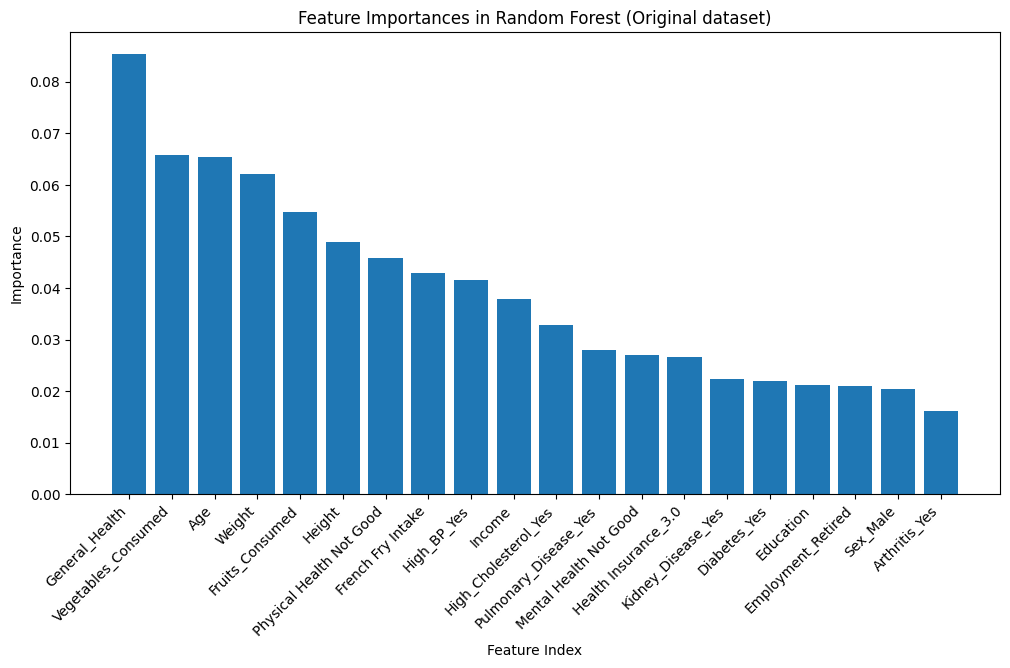

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][0:20]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances in Random Forest (Original dataset)")
plt.bar(range(20), importances[indices], align='center')
plt.xticks(range(20), X_train.iloc[:,indices], rotation=45, ha='right')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

SMOTE dataset

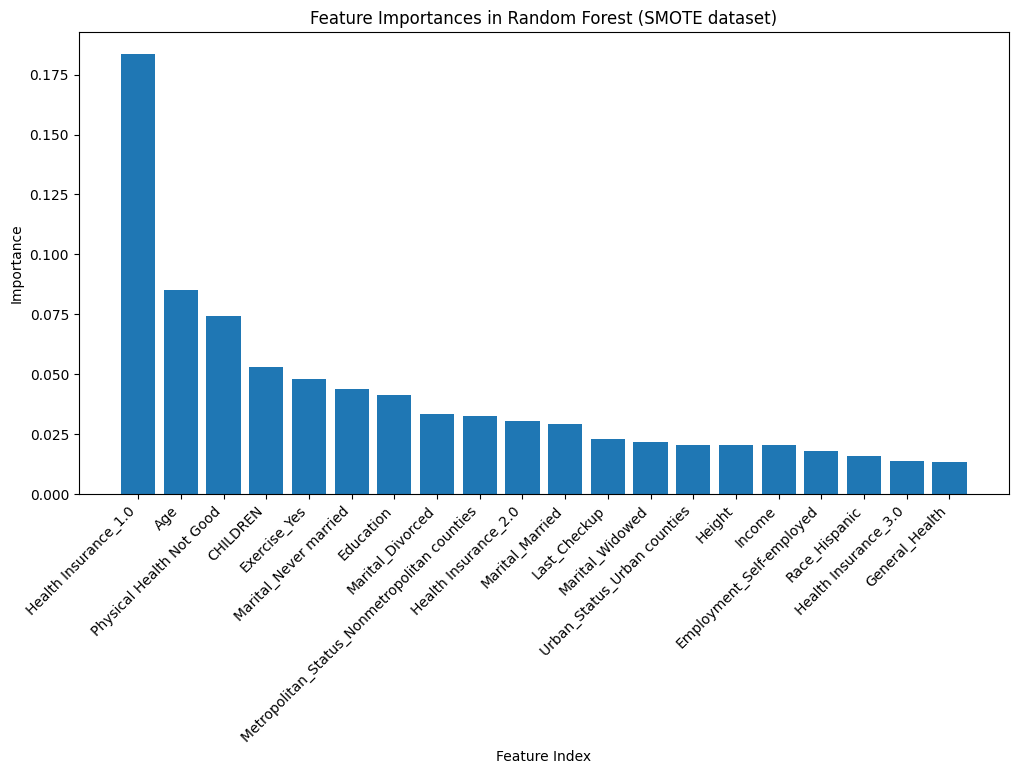

In [ ]:
importances = rf_smote.feature_importances_
indices = np.argsort(importances)[::-1][0:20]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances in Random Forest (SMOTE dataset)")
plt.bar(range(20), importances[indices], align='center')
plt.xticks(range(20), X_train_smote.iloc[:,indices], rotation=45, ha='right')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

ADASYN dataset

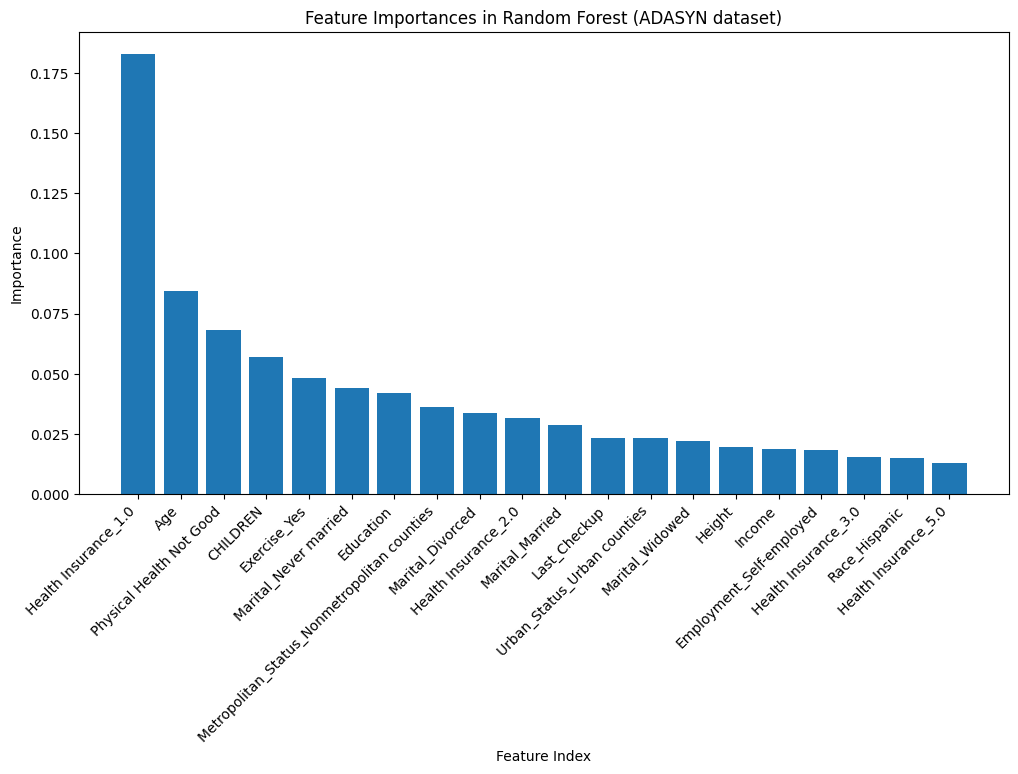

In [ ]:
importances = rf_ada.feature_importances_
indices = np.argsort(importances)[::-1][0:20]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances in Random Forest (ADASYN dataset)")
plt.bar(range(20), importances[indices], align='center')
plt.xticks(range(20), X_train_ada.iloc[:,indices], rotation=45, ha='right')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

## 7.3 XgBoost Classifier

### 7.3.1 XgBoost Classifier + Original dataset

In [ ]:
#define hyperparameters to tune
xgb_clf = xgb.XGBClassifier()
distributions = dict(max_depth=[5, 10, 15],
                     learning_rate = [0.1, 0.01],
                     n_estimators=[2, 5, 10],
                     subsample=[0.6, 0.9])

rscv = RandomizedSearchCV(xgb_clf, distributions, random_state=42)

In [ ]:
#find best parameters for original dataset
y_train = pd.Series(map(lambda x: 1 if x =='Yes' else 0, y_train))
y_test = pd.Series(map(lambda x: 1 if x =='Yes' else 0, y_test))
search = rscv.fit(X_train, y_train)
param = search.best_params_
param

{'subsample': 0.6, 'n_estimators': 10, 'max_depth': 15, 'learning_rate': 0.1}

In [ ]:
#Random forest using original dataset
xbg_best = xgb.XGBClassifier(max_depth=param.get('max_depth'),
                            learning_rate=param.get('learning_rate'),
                            n_estimators=param.get('n_estimators'),
                            subsample = param.get('subsample'))
xbg_best.fit(X_train, y_train)
y_pred_train = xbg_best.predict(X_train)
y_pred = xbg_best.predict(X_test)

print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))

print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Training Accuracy: 0.9445407279029463

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97    139914
           1       0.99      0.02      0.04      8375

    accuracy                           0.94    148289
   macro avg       0.97      0.51      0.50    148289
weighted avg       0.95      0.94      0.92    148289

Testing Accuracy: 0.9429452582883577

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     59931
           1       0.43      0.00      0.01      3622

    accuracy                           0.94     63553
   macro avg       0.69      0.50      0.49     63553
weighted avg       0.91      0.94      0.92     63553



### 7.3.2 XgBoost Classifier + SMOTE

In [ ]:
#find best parameters for original dataset
y_train_smote = pd.Series(map(lambda x: 1 if x =='Yes' else 0, y_train_smote))
y_test_smote = pd.Series(map(lambda x: 1 if x =='Yes' else 0, y_test_smote))
search = rscv.fit(X_train_smote, y_train_smote)
param = search.best_params_
param

{'subsample': 0.9, 'n_estimators': 10, 'max_depth': 15, 'learning_rate': 0.1}

In [ ]:
#Random forest using original dataset
xbg_best = xgb.XGBClassifier(max_depth=param.get('max_depth'),
                            learning_rate=param.get('learning_rate'),
                            n_estimators=param.get('n_estimators'),
                            subsample = param.get('subsample'))
xbg_best.fit(X_train_smote, y_train_smote)
y_pred_train = xbg_best.predict(X_train_smote)
y_pred = xbg_best.predict(X_test_smote)

print("Training Accuracy:", accuracy_score(y_train_smote, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train_smote, y_pred_train))

print("Testing Accuracy:", accuracy_score(y_test_smote, y_pred))
print("\nClassification Report:\n", classification_report(y_test_smote, y_pred))

Training Accuracy: 0.9400382439931018

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95    139846
           1       0.98      0.86      0.91     83980

    accuracy                           0.94    223826
   macro avg       0.95      0.92      0.93    223826
weighted avg       0.94      0.94      0.94    223826

Testing Accuracy: 0.9297687801013281

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95     59999
           1       0.98      0.83      0.90     35927

    accuracy                           0.93     95926
   macro avg       0.94      0.91      0.92     95926
weighted avg       0.93      0.93      0.93     95926



### 7.3.3 XgBoost Classifier + ADASYN

In [ ]:
#find best parameters for original dataset
y_train_ada = pd.Series(map(lambda x: 1 if x =='Yes' else 0, y_train_ada))
y_test_ada = pd.Series(map(lambda x: 1 if x =='Yes' else 0, y_test_ada))
search = rscv.fit(X_train_ada, y_train_ada)
param = search.best_params_
param

{'subsample': 0.9, 'n_estimators': 10, 'max_depth': 15, 'learning_rate': 0.01}

In [ ]:
#Random forest using original dataset
xbg_best = xgb.XGBClassifier(max_depth=param.get('max_depth'),
                            learning_rate=param.get('learning_rate'),
                            n_estimators=param.get('n_estimators'),
                            subsample = param.get('subsample'))
xbg_best.fit(X_train_ada, y_train_ada)
y_pred_train = xbg_best.predict(X_train_ada)
y_pred = xbg_best.predict(X_test_ada)

print("Training Accuracy:", accuracy_score(y_train_ada, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train_ada, y_pred_train))

print("Testing Accuracy:", accuracy_score(y_test_ada, y_pred))
print("\nClassification Report:\n", classification_report(y_test_ada, y_pred))

Training Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    224611

    accuracy                           1.00    224611
   macro avg       1.00      1.00      1.00    224611
weighted avg       1.00      1.00      1.00    224611

Testing Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     96263

    accuracy                           1.00     96263
   macro avg       1.00      1.00      1.00     96263
weighted avg       1.00      1.00      1.00     96263



## 7.4 Neural Networks

### 7.4.1 Neural Network Classifier + SMOTE

In [ ]:
# Define the input shape
input_shape = X_train_smote.shape[1]

# Model 1
model_1 = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape,)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Model 2 - Change in number of neurons and dropout rate
model_2 = Sequential([
    Dense(64, activation='relu', input_shape=(input_shape,)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
model_2.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Model 3 - Further change in number of neurons and dropout rate
model_3 = Sequential([
    Dense(256, activation='relu', input_shape=(input_shape,)),
    Dropout(0.4),
    BatchNormalization(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    BatchNormalization(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
model_3.compile(optimizer=Adam(learning_rate=0.002), loss='binary_crossentropy', metrics=['accuracy'])

# training each model seperately

# Train Model 1
history_1 = model_1.fit(X_train_smote, y_train_smote, epochs=10, validation_split=0.2)
model_1.evaluate(X_test_smote, y_test_smote)

# Train Model 2
history_2 = model_2.fit(X_train_smote, y_train_smote, epochs=10, validation_split=0.2)
model_2.evaluate(X_test_smote, y_test_smote)

# Train Model 3
history_3 = model_3.fit(X_train_smote, y_train_smote, epochs=10, validation_split=0.2)
model_3.evaluate(X_test_smote, y_test_smote)


In [ ]:
# Predictions for Model 1
predictions_1 = model_1.predict(X_test_smote)
predictions_1 = [1 if x > 0.5 else 0 for x in predictions_1]

# Classification report for Model 1
print("Classification Report for Model 1:")
print(classification_report(y_test_smote, predictions_1))

# Predictions for Model 2
predictions_2 = model_2.predict(X_test_smote)
predictions_2 = [1 if x > 0.5 else 0 for x in predictions_2]

# Classification report for Model 2
print("Classification Report for Model 2:")
print(classification_report(y_test_smote, predictions_2))

# Predictions for Model 3
predictions_3 = model_3.predict(X_test_smote)
predictions_3 = [1 if x > 0.5 else 0 for x in predictions_3]

# Classification report for Model 3
print("Classification Report for Model 3:")
print(classification_report(y_test_smote, predictions_3))

2998/2998 [==============================] - 12s 4ms/step
Classification Report for Model 1:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     59999
           1       0.97      0.84      0.90     35927

    accuracy                           0.93     95926
   macro avg       0.94      0.91      0.92     95926
weighted avg       0.93      0.93      0.93     95926

2998/2998 [==============================] - 6s 2ms/step
Classification Report for Model 2:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     59999
           1       0.97      0.84      0.90     35927

    accuracy                           0.93     95926
   macro avg       0.94      0.91      0.92     95926
weighted avg       0.93      0.93      0.93     95926

2998/2998 [==============================] - 12s 4ms/step
Classification Report for Model 3:
              precision    recall  f1-score   support

           0 

### 7.4.2 Neural Network Classifier + ADASYN

In [ ]:
# Define the input shape
input_shape = X_train_ada.shape[1]

# Model 1
model_1 = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape,)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Model 2 - Change in number of neurons and dropout rate
model_2 = Sequential([
    Dense(64, activation='relu', input_shape=(input_shape,)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
model_2.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Model 3 - Further change in number of neurons and dropout rate
model_3 = Sequential([
    Dense(256, activation='relu', input_shape=(input_shape,)),
    Dropout(0.4),
    BatchNormalization(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    BatchNormalization(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
model_3.compile(optimizer=Adam(learning_rate=0.002), loss='binary_crossentropy', metrics=['accuracy'])

# training each model seperately

# Train Model 1
history_1 = model_1.fit(X_train_ada, y_train_ada, epochs=10, validation_split=0.2)
print(model_1.evaluate(X_test_ada, y_test_ada))

# Train Model 2
history_2 = model_2.fit(X_train_ada, y_train_ada, epochs=10, validation_split=0.2)
print(model_2.evaluate(X_test_ada, y_test_ada))

# Train Model 3
history_3 = model_3.fit(X_train_ada, y_train_ada, epochs=10, validation_split=0.2)
print(model_3.evaluate(X_test_ada, y_test_ada))

# Predictions for Model 1
predictions_1 = model_1.predict(X_test_ada)
predictions_1 = [1 if x > 0.5 else 0 for x in predictions_1]

# Classification report for Model 1
print("Classification Report for Model 1:")
print(classification_report(y_test_ada, predictions_1))

# Predictions for Model 2
predictions_2 = model_2.predict(X_test_ada)
predictions_2 = [1 if x > 0.5 else 0 for x in predictions_2]

# Classification report for Model 2
print("Classification Report for Model 2:")
print(classification_report(y_test_ada, predictions_2))

# Predictions for Model 3
predictions_3 = model_3.predict(X_test_ada)
predictions_3 = [1 if x > 0.5 else 0 for x in predictions_3]

# Classification report for Model 3
print("Classification Report for Model 3:")
print(classification_report(y_test_ada, predictions_3))

Epoch 1/10
5616/5616 [==============================] - 51s 8ms/step - loss: 0.3664 - accuracy: 0.9044 - val_loss: 0.2218 - val_accuracy: 0.9265
Epoch 2/10
5616/5616 [==============================] - 46s 8ms/step - loss: 0.2463 - accuracy: 0.9163 - val_loss: 0.2156 - val_accuracy: 0.9271
Epoch 3/10
5616/5616 [==============================] - 67s 12ms/step - loss: 0.2398 - accuracy: 0.9199 - val_loss: 0.2139 - val_accuracy: 0.9282
Epoch 4/10
5616/5616 [==============================] - 57s 10ms/step - loss: 0.2419 - accuracy: 0.9222 - val_loss: 0.2149 - val_accuracy: 0.9293
Epoch 5/10
5616/5616 [==============================] - 46s 8ms/step - loss: 0.2436 - accuracy: 0.9238 - val_loss: 0.2227 - val_accuracy: 0.9280
Epoch 6/10
5616/5616 [==============================] - 46s 8ms/step - loss: 0.2370 - accuracy: 0.9251 - val_loss: 0.2245 - val_accuracy: 0.9281
Epoch 7/10
5616/5616 [==============================] - 43s 8ms/step - loss: 0.2350 - accuracy: 0.9249 - val_loss: 0.2207 - val_

## 7.5 Anomaly Detection

In this section, we tried treating this as an anomanly detection problem, rather than a binary classification problem, to see if it fare any better. The only change with treating this as an anomaly detection problem is the inherent assumption that one of the classes is **rare** compared to the other class.

Although this seemed like a unique perspective, it did not yield any good results and performed bad overall.

### 7.5.1 Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

# Since '1' is the minority class, we will treat it as the anomaly class
# Adjusting the contamination parameter is crucial, it should approximate the proportion of the minority class
estimated_contamination = np.mean(y_train_smote)

# Initializing the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=estimated_contamination, random_state=42)

# Fitting the model to the training data
iso_forest.fit(X_train_smote)

# Making predictions
y_pred_train = iso_forest.predict(X_train_smote)
y_pred_test = iso_forest.predict(X_test_smote)

# Adjusting prediction values to match the target labels
# Isolation Forest marks anomalies as -1, so we change -1 to 1 and 1 to 0
y_pred_train = np.where(y_pred_train == -1, 1, 0)
y_pred_test = np.where(y_pred_test == -1, 1, 0)

# Evaluation
print("Accuracy Score on Test Data:")
print(accuracy_score(y_test_smote, y_pred_test))
print("Classification Report on Test Data:")
print(classification_report(y_test_smote, y_pred_test))

Accuracy Score on Test Data:
0.40330046077184495
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52     59999
           1       0.20      0.20      0.20     35927

    accuracy                           0.40     95926
   macro avg       0.36      0.36      0.36     95926
weighted avg       0.40      0.40      0.40     95926



### 7.5.2 One class SVM

In [ ]:
from sklearn.svm import OneClassSVM

X_train_normal = X_train_smote[y_train_smote == 0]

# Initialize One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma='auto')

# Train the model only on the normal data
oc_svm.fit(X_train_normal)

# Predictions
y_pred_train = oc_svm.predict(X_train_smote)
y_pred_test = oc_svm.predict(X_test_smote)

# Adjust predictions: -1 for outliers (anomalies) and 1 for inliers (normal)
y_pred_train = np.where(y_pred_train == -1, 1, 0)
y_pred_test = np.where(y_pred_test == -1, 1, 0)

# Evaluate the model
print("Accuracy Score on Test Data:")
print(accuracy_score(y_test_smote, y_pred_test))
print("Classification Report on Test Data:")
print(classification_report(y_test_smote, y_pred_test))

Accuracy Score on Test Data:
0.3837020203073202
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.51      0.50      0.51     59999
           1       0.18      0.18      0.18     35927

    accuracy                           0.38     95926
   macro avg       0.34      0.34      0.34     95926
weighted avg       0.39      0.38      0.38     95926



# SECTION IX: METRIC & EVALUATION

## 9.1 SHAP Values

In [ ]:
explainer = shap.TreeExplainer(rf_smote)
shap_values = explainer.shap_values(X_test_smote)

shap.summary_plot(shap_values, X_test_smote)

## ADD AUC ROC CURVES, PLOT F1 score


# SECTION X: CONCLUSION